In [399]:
# # Online Shoppers Purchase Intention Prediction
# 
# ## Objective
# Predict whether an online shopping session will end in revenue generation (purchase) or not.

1. Import Libraries and Setup

In [400]:
# Import all required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [401]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [402]:
RANDOM_STATE = 8
TEST_SIZE = 0.2

2. Load and Explore Data

In [403]:
# Load the dataset
df = pd.read_csv('online_shoppers_intention.csv')

# Basic information
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

Dataset Shape: (12330, 18)

Columns: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']

Data Types:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Missing Value

In [404]:
# First few rows
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [405]:
# Statistical summary
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [406]:
# Check for duplicates and remove them
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Shape after removing duplicates: {df.shape}")

Number of duplicate rows: 125
Shape after removing duplicates: (12205, 18)


3. Target Variable Analysis

In [407]:
# Class distribution
def class_distribution(df, target_col):
    return df[target_col].value_counts(normalize=True)

target_col = 'Revenue'
distribution = class_distribution(df, target_col)
print(f"\nClass Distribution for {target_col}:")
print(distribution)
print(f"Class Imbalance Ratio: {distribution[False]/distribution[True]:.2f}:1")



Class Distribution for Revenue:
Revenue
False    0.843671
True     0.156329
Name: proportion, dtype: float64
Class Imbalance Ratio: 5.40:1


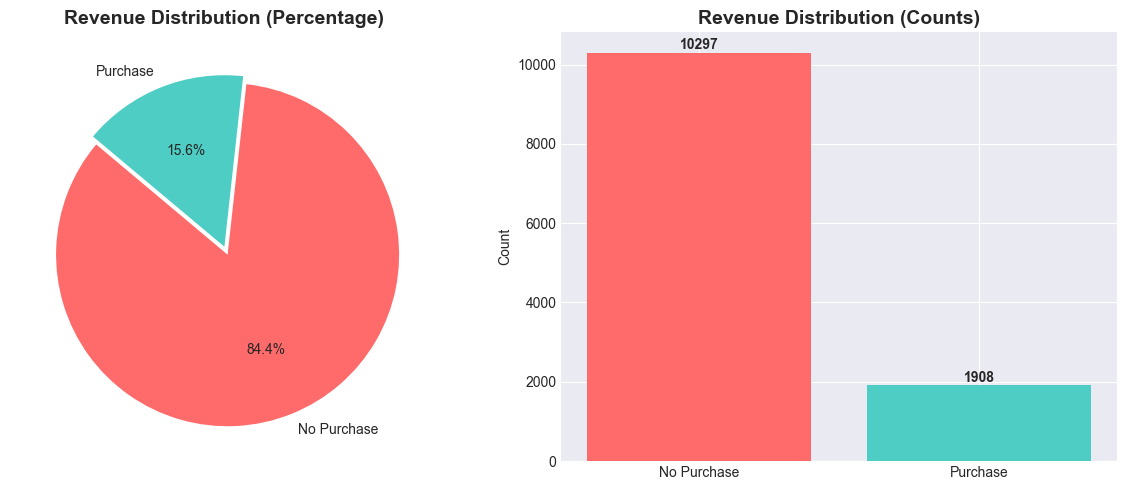

In [408]:
# Plot conversion distribution with improved aesthetics
def plot_conversion_distribution(df, target_col):
    distribution = df[target_col].value_counts(normalize=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart
    colors = ['#FF6B6B', '#4ECDC4']
    ax1.pie(distribution, labels=['No Purchase', 'Purchase'], autopct='%1.1f%%', 
            startangle=140, colors=colors, explode=[0.05, 0])
    ax1.set_title('Revenue Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    # Bar chart for counts
    counts = df[target_col].value_counts()
    ax2.bar(['No Purchase', 'Purchase'], counts, color=colors)
    ax2.set_title('Revenue Distribution (Counts)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Count')
    
    # Add value labels on bars
    for i, v in enumerate(counts):
        ax2.text(i, v + 100, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_conversion_distribution(df, target_col)

4. Feature Analysis

In [409]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Remove Revenue from numerical cols if present
if 'Revenue' in numerical_cols:
    numerical_cols.remove('Revenue')
if 'Revenue' in categorical_cols:
    categorical_cols.remove('Revenue')

print(f"Numerical Features ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical Features ({len(categorical_cols)}): {categorical_cols}")

Numerical Features (14): ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']

Categorical Features (3): ['Month', 'VisitorType', 'Weekend']


4.1 Numerical Features Distribution

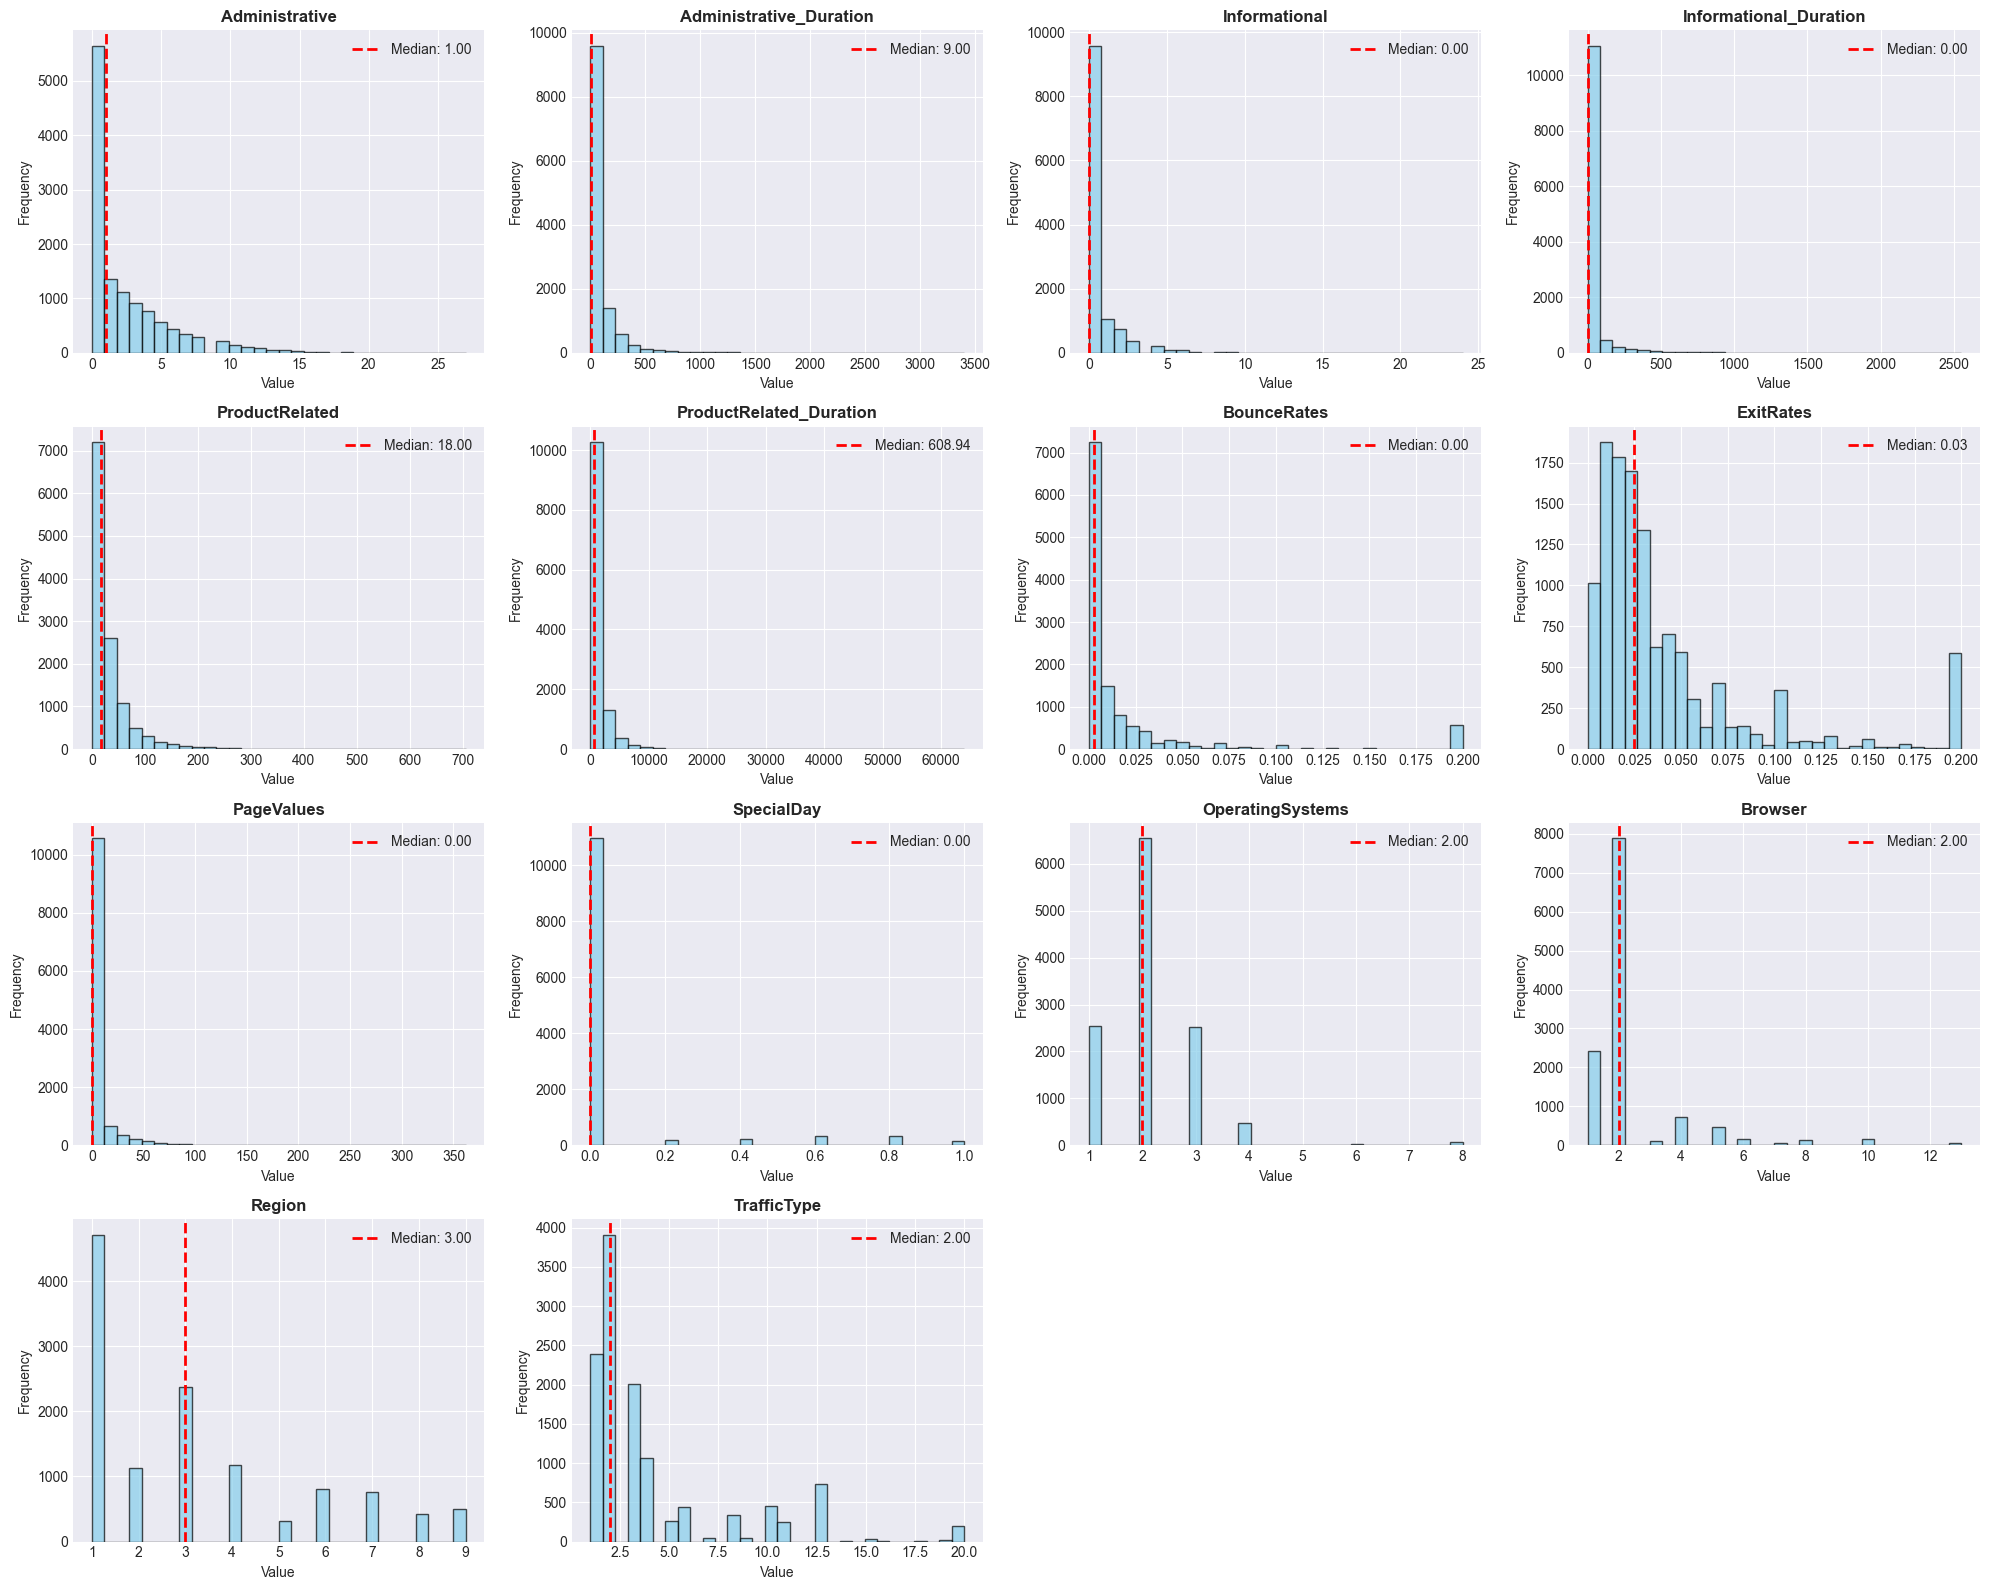

In [410]:
# Plot distributions for numerical features
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        # Histogram
        axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        
        # Add median line
        median_val = df[col].median()
        axes[idx].axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        axes[idx].legend()

# Remove empty subplots
for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

4.2 Outlier Detection and Removal

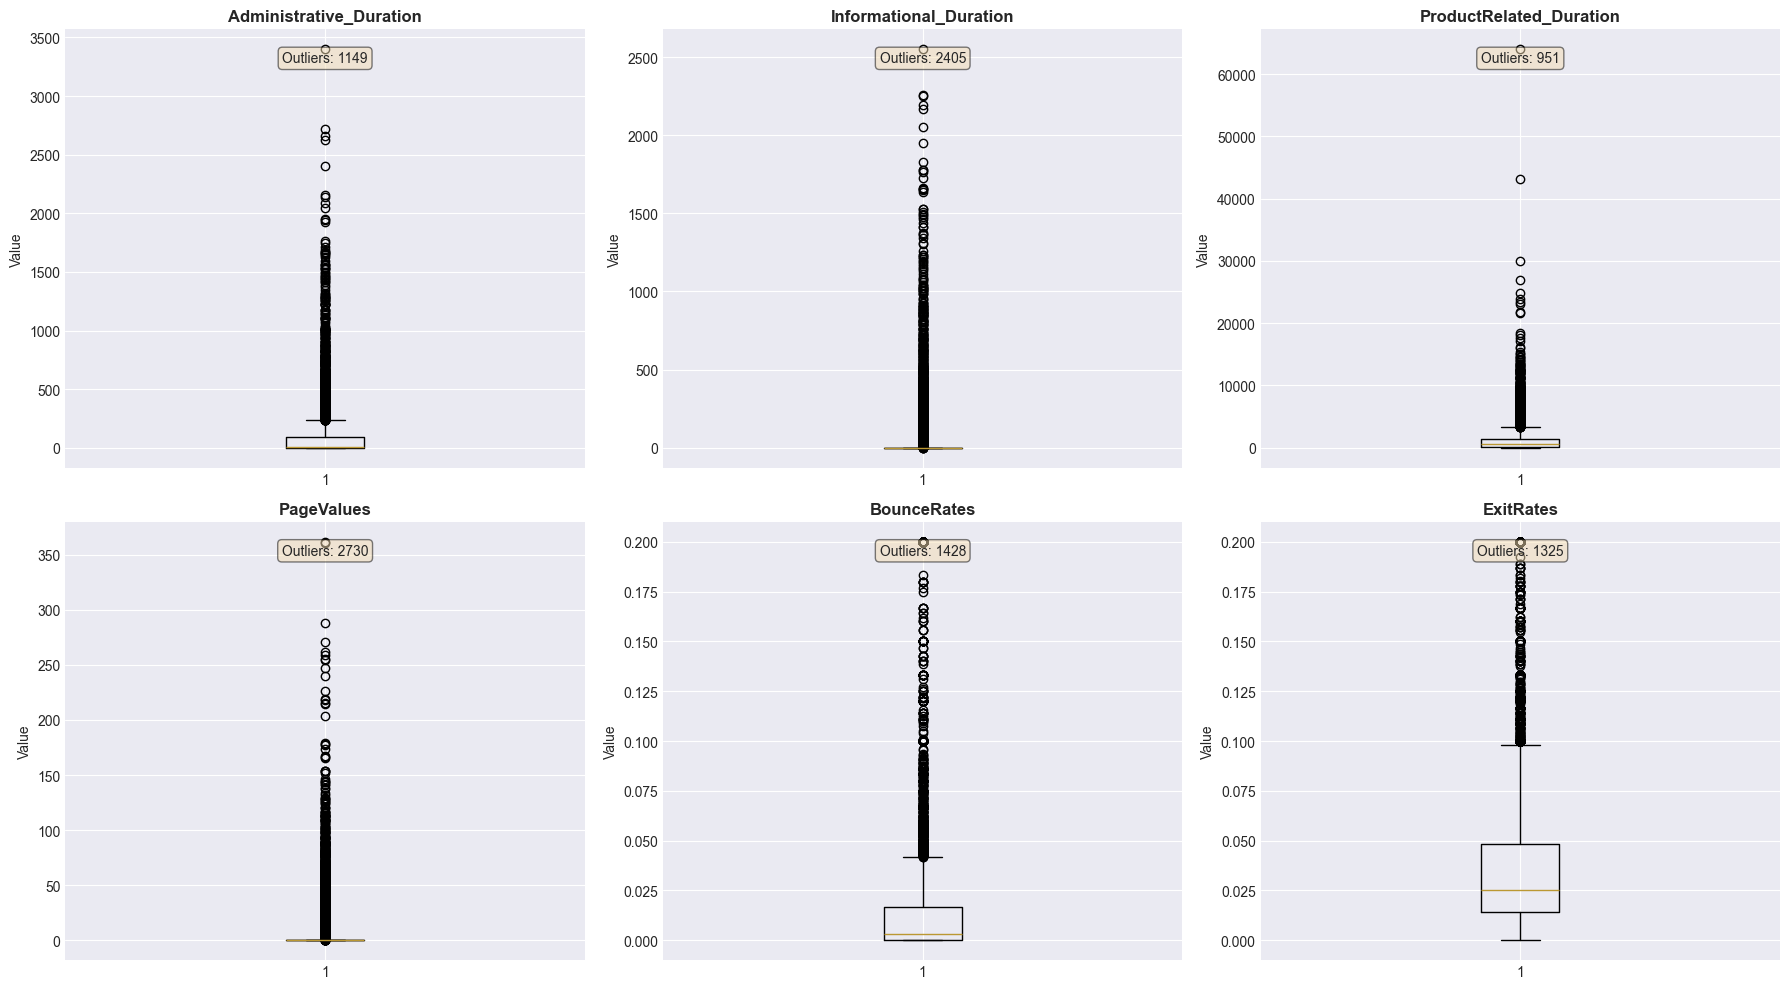

In [411]:
# Boxplot for outlier visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Focus on duration and value columns for outlier analysis
outlier_cols = ['Administrative_Duration', 'Informational_Duration', 
                'ProductRelated_Duration', 'PageValues', 'BounceRates', 'ExitRates']

for idx, col in enumerate(outlier_cols):
    if idx < len(axes):
        box_data = df[col]
        axes[idx].boxplot(box_data)
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Value')
        
        # Calculate outlier statistics
        Q1 = box_data.quantile(0.25)
        Q3 = box_data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((box_data < (Q1 - 1.5 * IQR)) | (box_data > (Q3 + 1.5 * IQR))).sum()
        axes[idx].text(0.5, 0.95, f'Outliers: {outliers}', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

Not using outliers due to the amount of outliers

In [412]:
# Remove outliers using IQR method for specific columns
'''def remove_outliers_iqr(df, columns, k=1.5):
    """Remove outliers using IQR method"""
    df_clean = df.copy()
    outliers_removed = {}
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        initial_shape = df_clean.shape[0]
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        outliers_removed[col] = initial_shape - df_clean.shape[0]
    
    return df_clean, outliers_removed

# Remove outliers from duration and page value columns only
columns_to_clean = ['Administrative_Duration', 'Informational_Duration', 
                    'ProductRelated_Duration', 'PageValues']

print(f"Shape before outlier removal: {df.shape}")
df_clean, outliers_info = remove_outliers_iqr(df, columns_to_clean)
print(f"Shape after outlier removal: {df_clean.shape}")
print(f"Total rows removed: {df.shape[0] - df_clean.shape[0]} ({(df.shape[0] - df_clean.shape[0])/df.shape[0]*100:.2f}%)")
print("\nOutliers removed by column:")
for col, count in outliers_info.items():
    print(f"  {col}: {count}")

df = df_clean'''

'def remove_outliers_iqr(df, columns, k=1.5):\n    """Remove outliers using IQR method"""\n    df_clean = df.copy()\n    outliers_removed = {}\n\n    for col in columns:\n        Q1 = df_clean[col].quantile(0.25)\n        Q3 = df_clean[col].quantile(0.75)\n        IQR = Q3 - Q1\n\n        lower_bound = Q1 - k * IQR\n        upper_bound = Q3 + k * IQR\n\n        initial_shape = df_clean.shape[0]\n        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]\n        outliers_removed[col] = initial_shape - df_clean.shape[0]\n\n    return df_clean, outliers_removed\n\n# Remove outliers from duration and page value columns only\ncolumns_to_clean = [\'Administrative_Duration\', \'Informational_Duration\', \n                    \'ProductRelated_Duration\', \'PageValues\']\n\nprint(f"Shape before outlier removal: {df.shape}")\ndf_clean, outliers_info = remove_outliers_iqr(df, columns_to_clean)\nprint(f"Shape after outlier removal: {df_clean.shape}")\nprint(f"Tot

4.3 Categorical Features Analysis

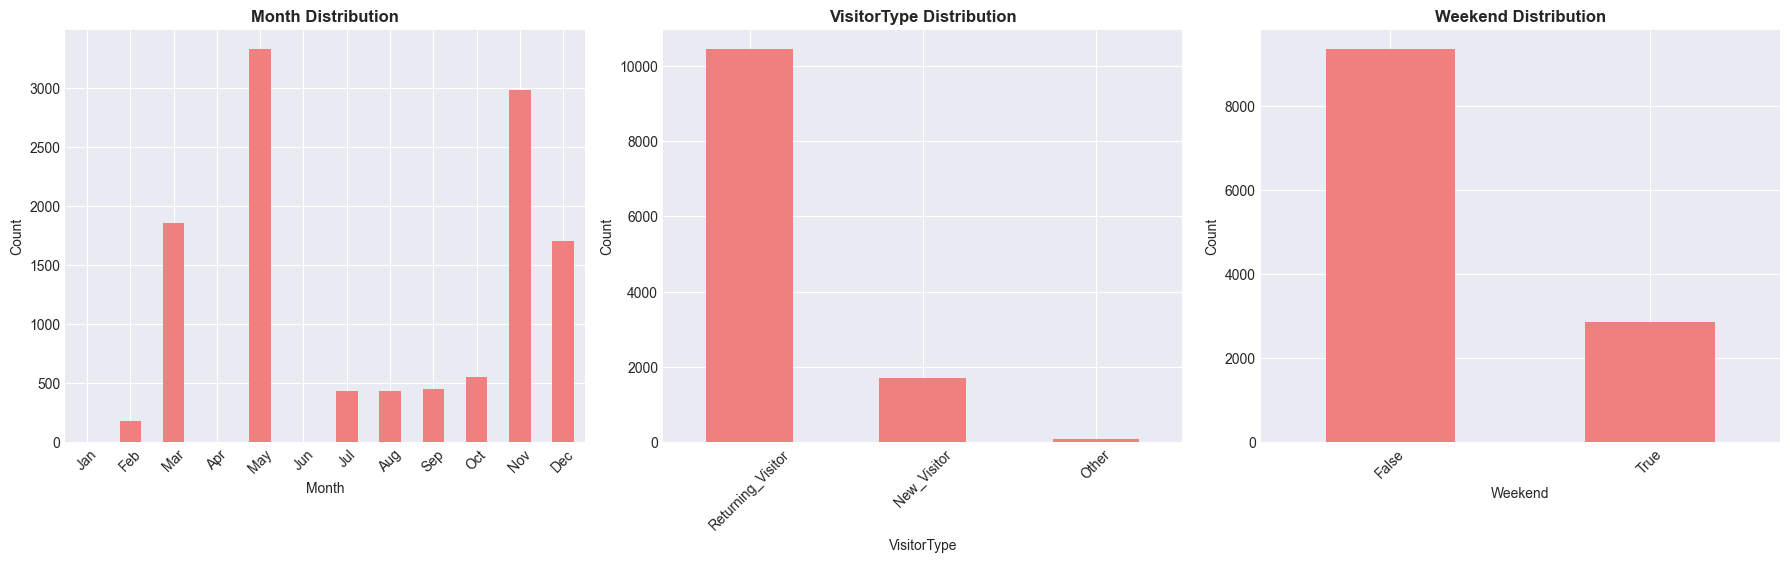

In [413]:
# Analyze categorical features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if idx < len(axes):
        if col == 'Month':
            # Order months correctly
            month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            df[col] = pd.Categorical(df[col], categories=month_order, ordered=True)
        
        value_counts = df[col].value_counts()
        
        # For VisitorType and Weekend, use regular bar plot
        if col in ['VisitorType', 'Weekend']:
            value_counts.plot(kind='bar', ax=axes[idx], color='lightcoral')
        else:
            # For others, sort by index to maintain order
            value_counts.sort_index().plot(kind='bar', ax=axes[idx], color='lightcoral')
        
        axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplots
for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


5. Feature Relationships with Target

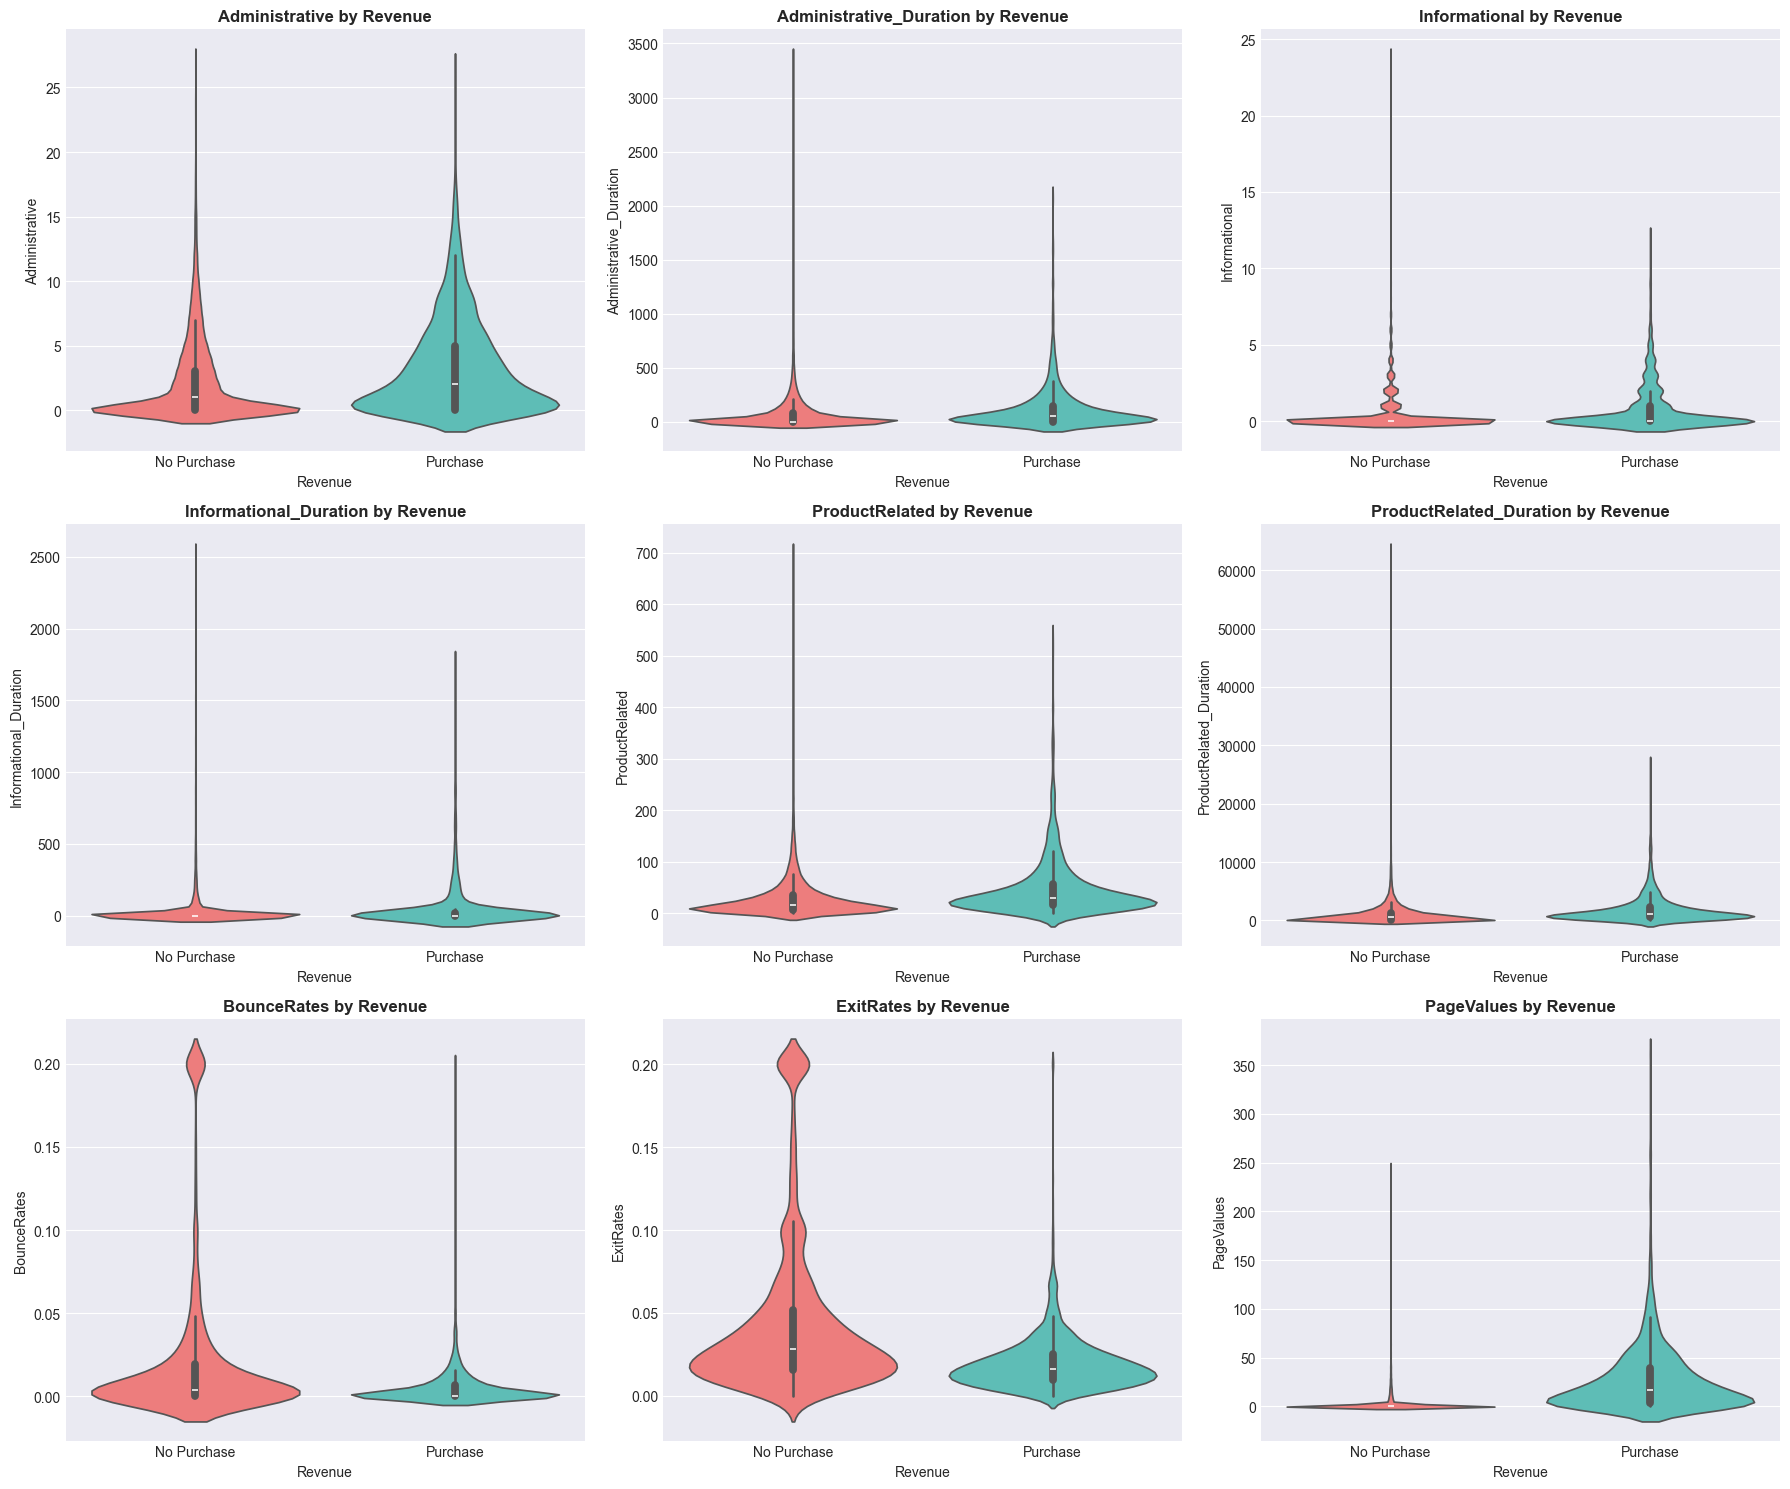

In [414]:
# Numerical features vs Revenue
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:9]):  # First 9 numerical features
    # Create violin plot
    df_plot = pd.DataFrame({col: df[col], 'Revenue': df['Revenue']})
    df_plot['Revenue'] = df_plot['Revenue'].map({True: 'Purchase', False: 'No Purchase'})
    
    sns.violinplot(data=df_plot, x='Revenue', y=col, ax=axes[idx], palette=['#FF6B6B', '#4ECDC4'])
    axes[idx].set_title(f'{col} by Revenue', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

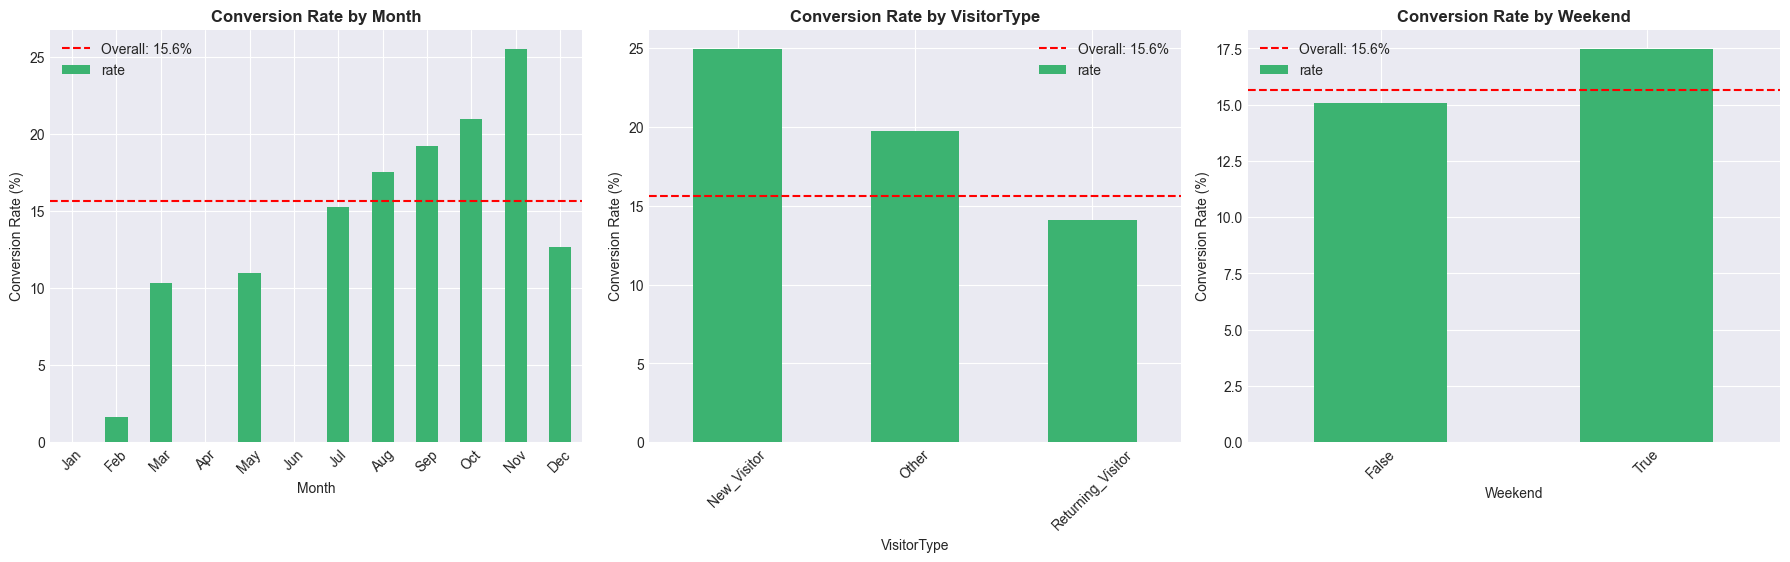

In [415]:
# Categorical features vs Revenue (Conversion Rate Analysis)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if idx < len(axes):
        # Calculate conversion rate for each category
        conversion_rates = df.groupby(col)['Revenue'].agg(['sum', 'count'])
        conversion_rates['rate'] = (conversion_rates['sum'] / conversion_rates['count'] * 100)
        
        # Plot
        if col == 'Month':
            conversion_rates = conversion_rates.reindex(
                ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            )
        
        conversion_rates['rate'].plot(kind='bar', ax=axes[idx], color='mediumseagreen')
        axes[idx].set_title(f'Conversion Rate by {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Conversion Rate (%)')
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add horizontal line for overall conversion rate
        overall_rate = df['Revenue'].mean() * 100
        axes[idx].axhline(y=overall_rate, color='red', linestyle='--', 
                         label=f'Overall: {overall_rate:.1f}%')
        axes[idx].legend()

# Remove empty subplots
for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

6. Correlation Analysis

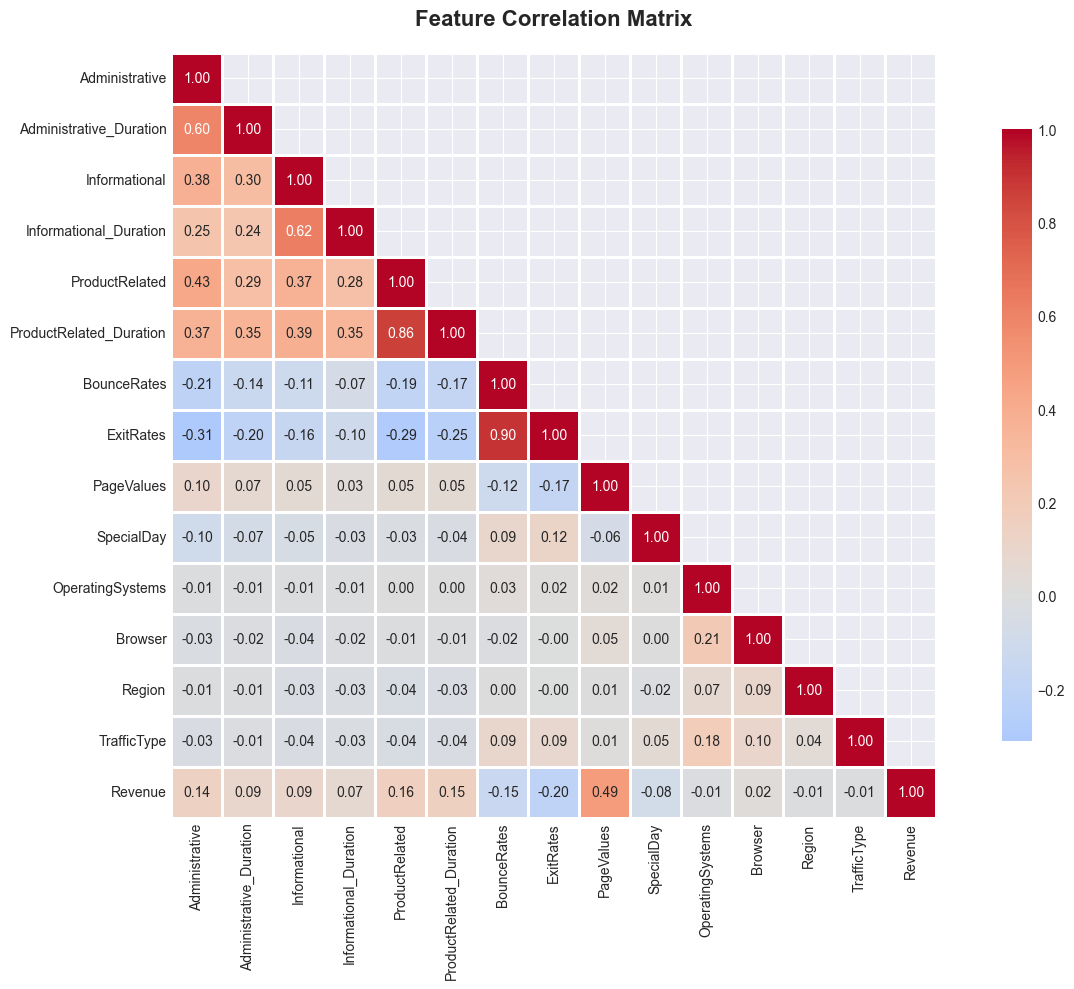

In [416]:
# Correlation matrix
plt.figure(figsize=(14, 10))

# Calculate correlation matrix (only numerical features)
numerical_df = df[numerical_cols + ['Revenue']]
correlation_matrix = numerical_df.corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix), k=1)

# Plot heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


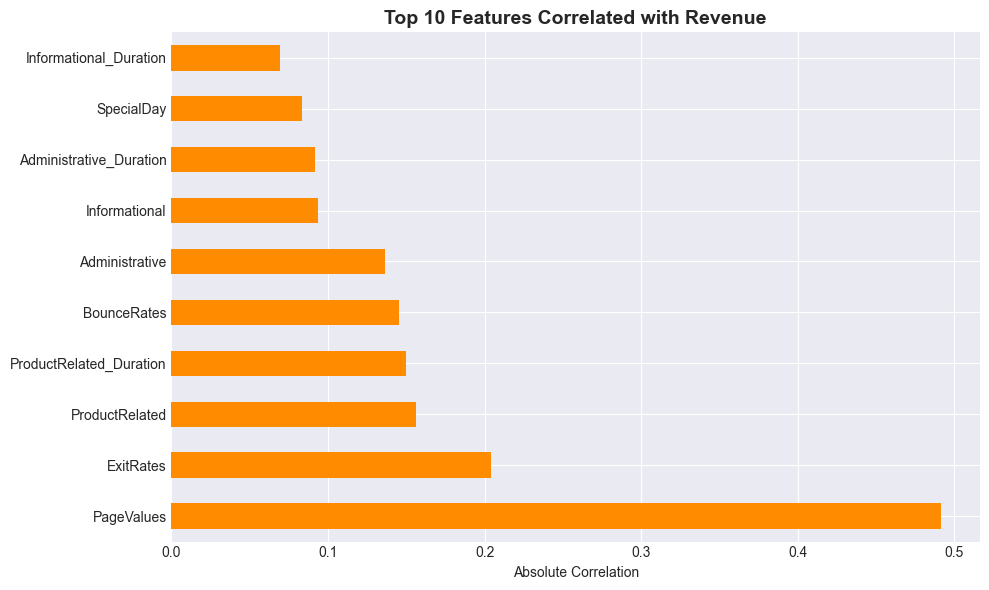

Features most correlated with Revenue:
PageValues: 0.492
ExitRates: 0.204
ProductRelated: 0.156
ProductRelated_Duration: 0.150
BounceRates: 0.145
Administrative: 0.136
Informational: 0.094
Administrative_Duration: 0.092
SpecialDay: 0.084
Informational_Duration: 0.069


In [417]:
# Features most correlated with Revenue
revenue_corr = correlation_matrix['Revenue'].abs().sort_values(ascending=False)[1:11]

plt.figure(figsize=(10, 6))
revenue_corr.plot(kind='barh', color='darkorange')
plt.title('Top 10 Features Correlated with Revenue', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

print("Features most correlated with Revenue:")
for feature, corr in revenue_corr.items():
    print(f"{feature}: {corr:.3f}")

7. Experimental: BounceRates Regression Analysis
 **Note:** This section analyzes BounceRates prediction as an experimental feature. The main target variable remains Revenue (purchase prediction).

In [418]:
# NOTE: The BounceRates regression section is preserved but marked as experimental
print("\n" + "="*80)
print("EXPERIMENTAL: BounceRates Regression Analysis")
print("Note: This is experimental - Revenue is the main target variable")
print("="*80)

# Make split train data for bouncerates (keeping original code)
def split_train_data(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train_br, X_test_br, y_train_br, y_test_br = split_train_data(df, 'BounceRates')

# One-hot encode categorical features for both train and test sets
X_train_encoded_br = pd.get_dummies(X_train_br)
X_test_encoded_br = pd.get_dummies(X_test_br)

# Align the columns of train and test sets
X_train_encoded_br, X_test_encoded_br = X_train_encoded_br.align(X_test_encoded_br, join='left', axis=1, fill_value=0)


EXPERIMENTAL: BounceRates Regression Analysis
Note: This is experimental - Revenue is the main target variable


In [419]:
# Linear regression model for BounceRates
from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

model_lr = train_linear_regression(X_train_encoded_br, y_train_br)

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

mse, r2 = evaluate_model(model_lr, X_test_encoded_br, y_test_br)
print(f"Linear Regression - Mean Squared Error: {mse:.4f}")
print(f"Linear Regression - R^2 Score: {r2:.4f}")

Linear Regression - Mean Squared Error: 0.0004
Linear Regression - R^2 Score: 0.8313


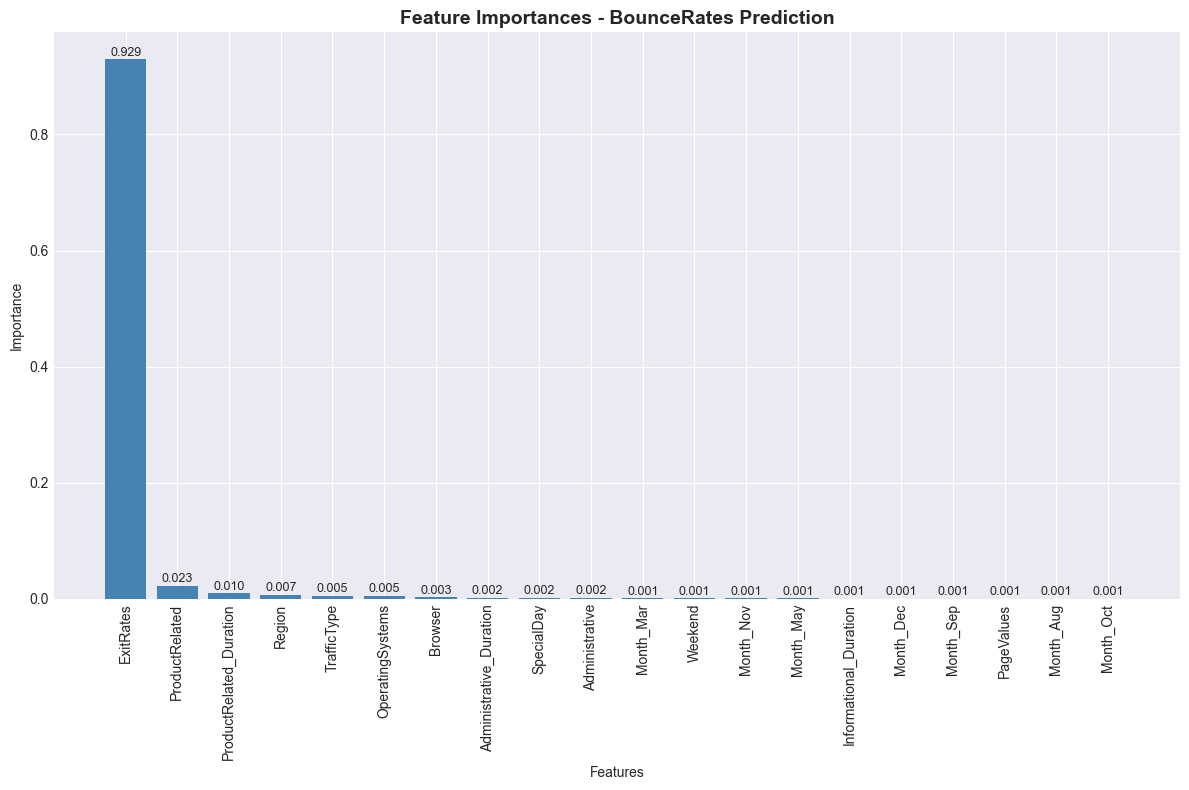

(array([ 6,  4,  5, 11, 12,  9, 10,  1,  8,  0, 17, 13, 25, 19,  3, 26, 23,
         7, 22, 24]),
 array([1.81800350e-03, 2.43641359e-03, 4.44574138e-04, 7.87363648e-04,
        2.28118064e-02, 9.83828480e-03, 9.29285889e-01, 6.59032999e-04,
        2.42995680e-03, 5.46208902e-03, 2.88680480e-03, 6.89308911e-03,
        5.48116672e-03, 1.20624289e-03, 2.94638516e-04, 0.00000000e+00,
        3.61629325e-04, 1.25152935e-03, 0.00000000e+00, 8.03068845e-04,
        0.00000000e+00, 4.84417518e-04, 5.64606539e-04, 6.98794472e-04,
        5.40266686e-04, 9.66536076e-04, 7.78561194e-04, 3.62623216e-04,
        5.79721809e-05, 3.94638783e-04]))

In [420]:
# Use RandomForestRegressor for continuous target
from sklearn.ensemble import RandomForestRegressor

# Feature importance for Random Forest Regressor
def train_random_forest(X_train, y_train):
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model

rf_model_br = train_random_forest(X_train_encoded_br, y_train_br)

# Enhanced feature importance plot
def plot_feature_importance(model, X_train, title="Feature Importances", top_n=20):
    importances = model.feature_importances_
    feature_names = X_train.columns
    indices = importances.argsort()[::-1][:top_n]  # Get top N features

    plt.figure(figsize=(12, 8))
    plt.title(title, fontsize=14, fontweight='bold')
    bars = plt.bar(range(len(indices)), importances[indices], align='center', color='steelblue')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return indices, importances

plot_feature_importance(rf_model_br, X_train_encoded_br, "Feature Importances - BounceRates Prediction")

In [421]:
# Predicting BounceRates using Random Forest Regressor
def predict_bouncerates(model, X_test):
    return model.predict(X_test)

y_pred_rf_br = predict_bouncerates(rf_model_br, X_test_encoded_br)

# Evaluate Random Forest Regressor model
def evaluate_rf_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

mse_rf, r2_rf = evaluate_rf_model(rf_model_br, X_test_encoded_br, y_test_br)
print(f"Random Forest Regressor - Mean Squared Error: {mse_rf:.5f}")
print(f"Random Forest Regressor - R^2 Score: {r2_rf:.4f}")


Random Forest Regressor - Mean Squared Error: 0.00015
Random Forest Regressor - R^2 Score: 0.9306


8. Main Analysis: Revenue (Purchase) Prediction


MAIN ANALYSIS: Revenue (Purchase) Prediction


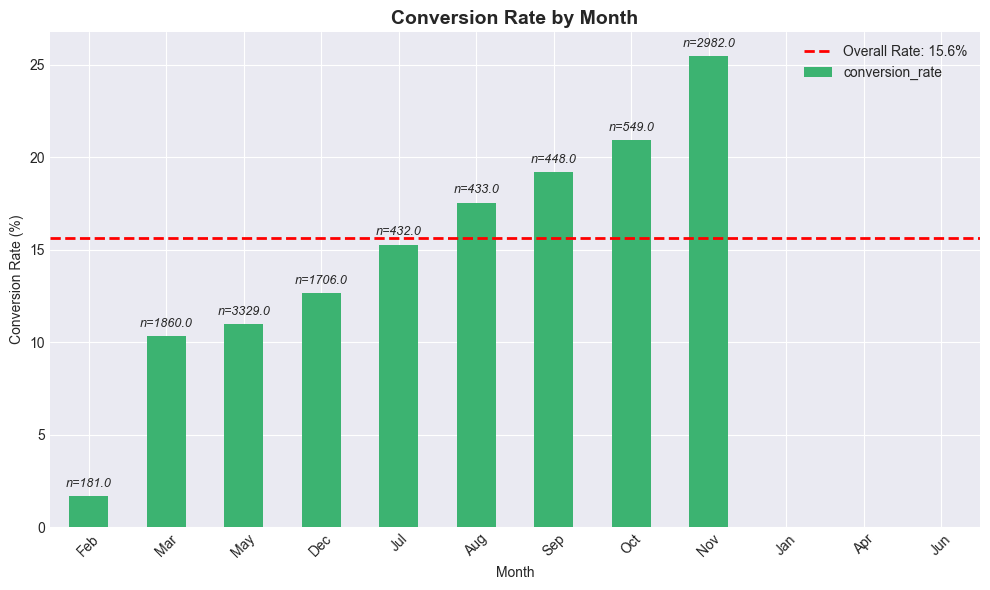

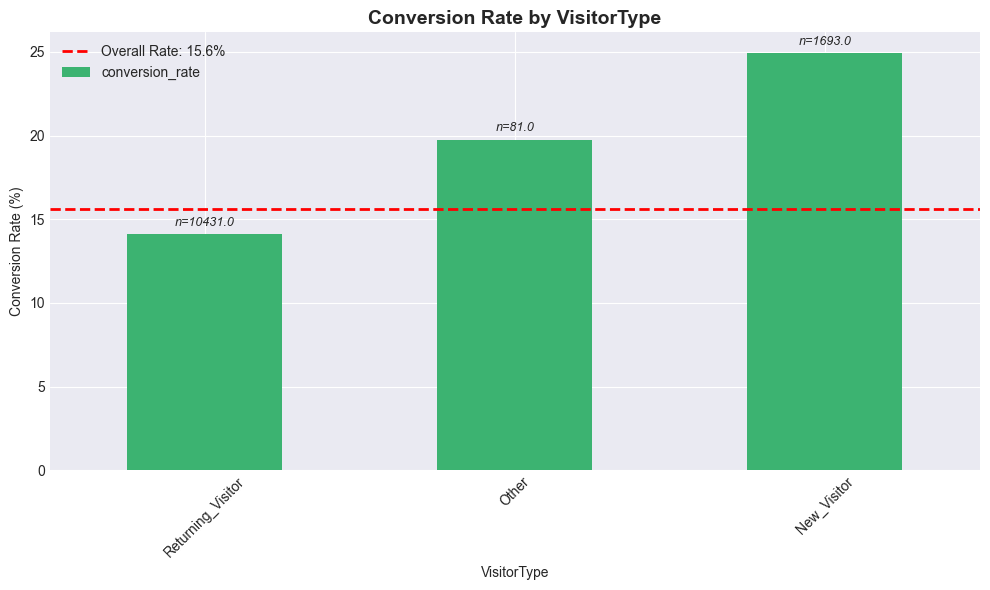

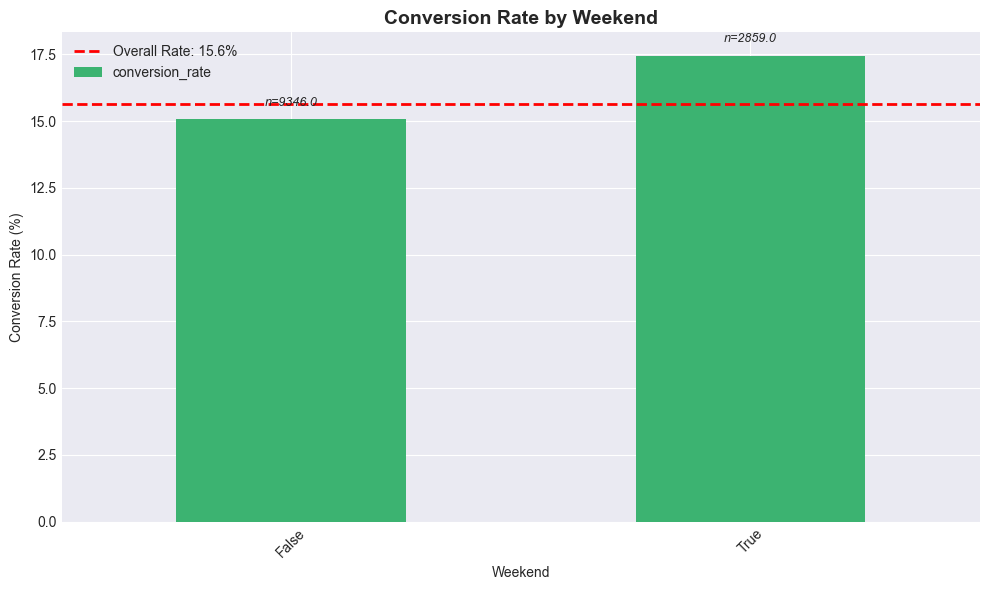

In [422]:
print("\n" + "="*80)
print("MAIN ANALYSIS: Revenue (Purchase) Prediction")
print("="*80)

# Relationship between categorical variables and Revenue - enhanced visualization
def plot_categorical_vs_revenue(df, categorical_col, target_col='Revenue'):
    plt.figure(figsize=(10, 6))
    
    # Calculate conversion rate and counts
    grouped = df.groupby(categorical_col)[target_col].agg(['mean', 'count'])
    grouped['conversion_rate'] = grouped['mean'] * 100
    
    # Sort by conversion rate
    grouped = grouped.sort_values('conversion_rate')
    
    # Create bar plot
    ax = grouped['conversion_rate'].plot(kind='bar', color='mediumseagreen')
    
    # Add count labels on bars
    for i, (idx, row) in enumerate(grouped.iterrows()):
        ax.text(i, row['conversion_rate'] + 0.5, f"n={row['count']}", 
                ha='center', fontsize=9, style='italic')
    
    # Add overall conversion rate line
    overall_rate = df[target_col].mean() * 100
    ax.axhline(y=overall_rate, color='red', linestyle='--', 
              label=f'Overall Rate: {overall_rate:.1f}%', linewidth=2)
    
    plt.title(f'Conversion Rate by {categorical_col}', fontsize=14, fontweight='bold')
    plt.xlabel(categorical_col)
    plt.ylabel('Conversion Rate (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    plot_categorical_vs_revenue(df, col, target_col)

9. Feature Correlation Analysis

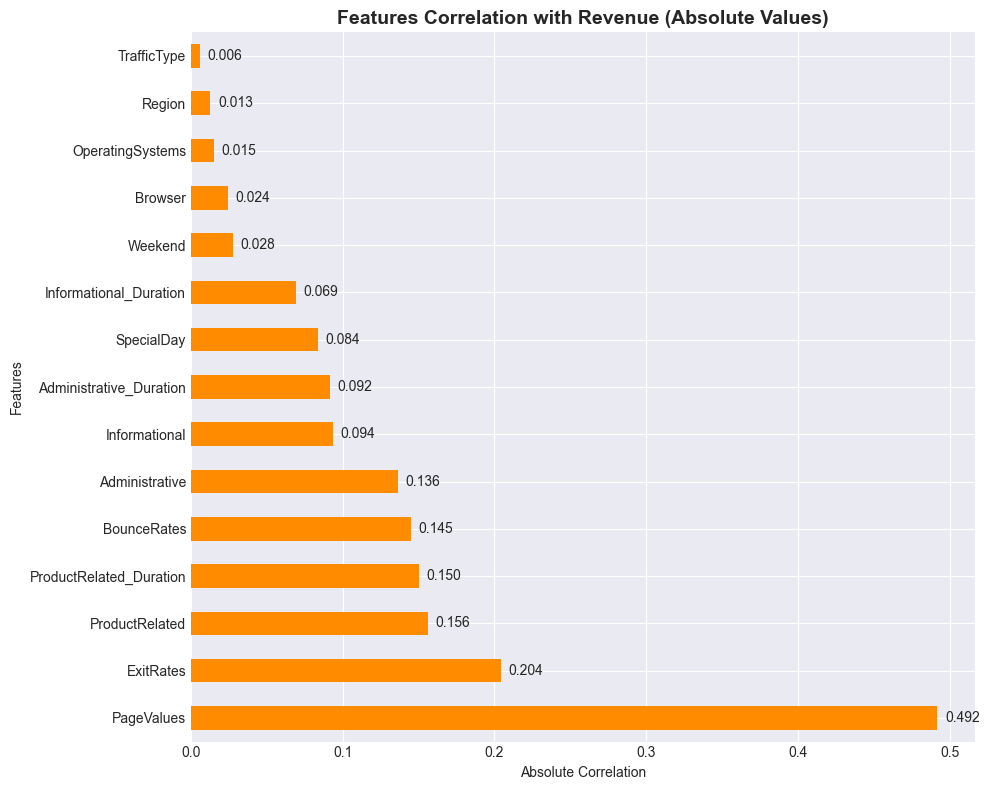

In [423]:
# Features correlate most with Revenue - enhanced
def plot_correlation_with_revenue(df, target_col='Revenue'):
    # Only use numerical columns for correlation
    numerical_df = df.select_dtypes(include=['float64', 'int64', 'bool'])
    correlation = numerical_df.corr()[target_col].abs().sort_values(ascending=False)
    
    # Remove self-correlation
    correlation = correlation[correlation.index != target_col]
    
    plt.figure(figsize=(10, 8))
    bars = correlation.plot(kind='barh', color='darkorange')
    plt.title(f'Features Correlation with {target_col} (Absolute Values)', fontsize=14, fontweight='bold')
    plt.xlabel('Absolute Correlation')
    plt.ylabel('Features')
    
    # Add value labels
    for i, v in enumerate(correlation):
        plt.text(v + 0.005, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return correlation

revenue_correlation = plot_correlation_with_revenue(df, target_col)

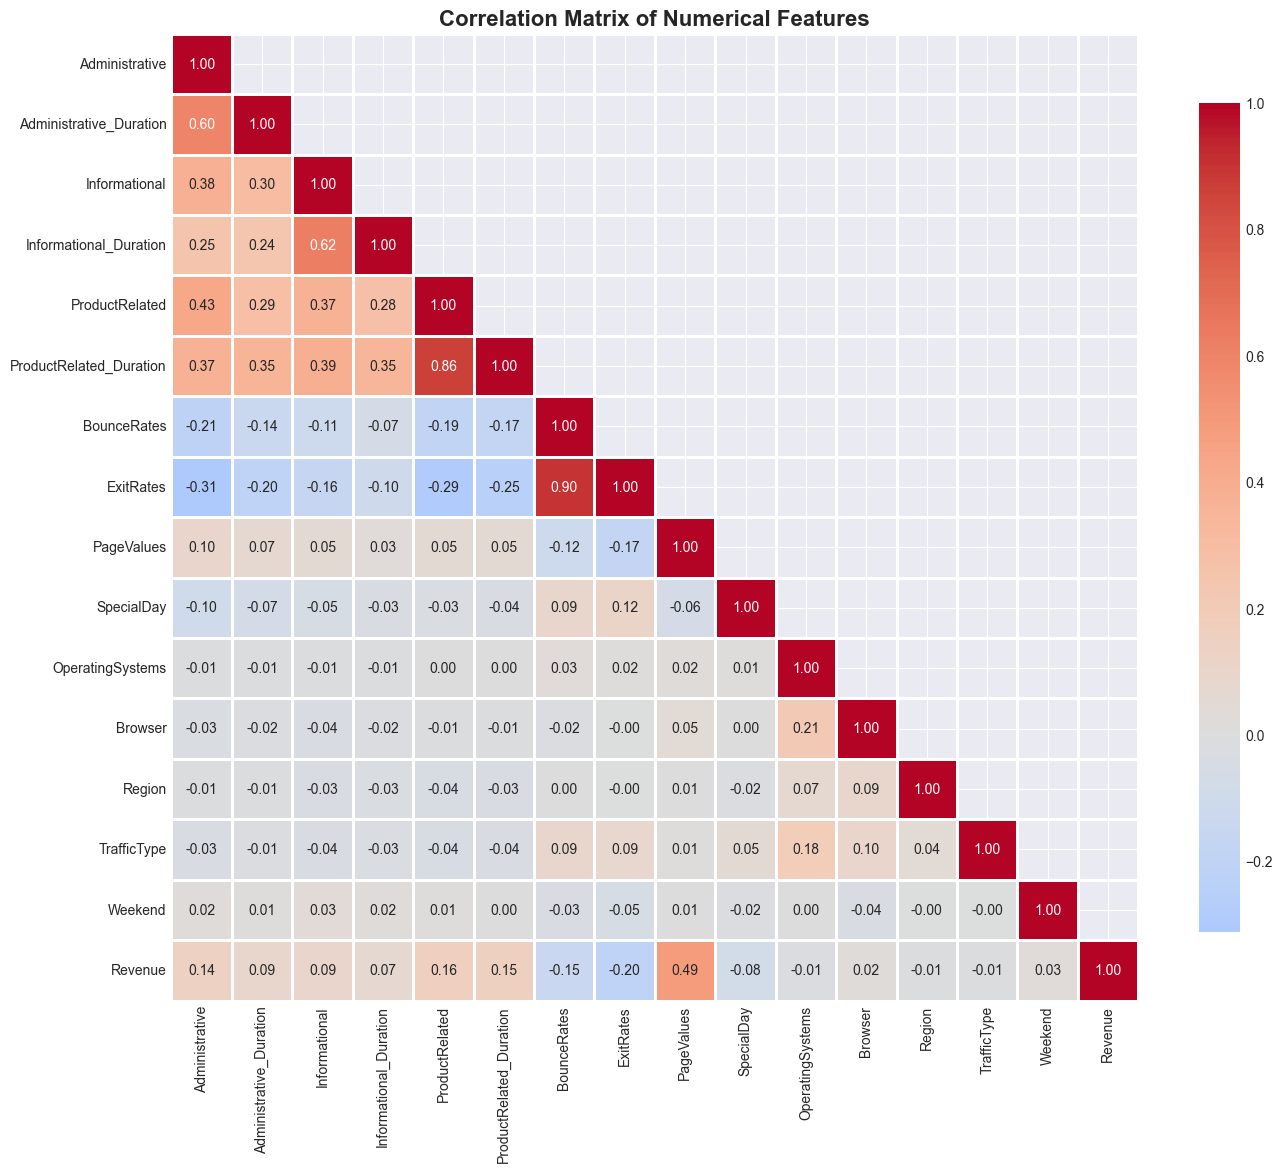

In [424]:
# Correlation matrix/heatmap of numerical features
def plot_correlation_matrix(df):
    # Select only numerical columns
    numerical_df = df.select_dtypes(include=['float64', 'int64', 'bool'])
    
    plt.figure(figsize=(14, 12))
    correlation_matrix = numerical_df.corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix), k=1)
    
    # Create heatmap with better styling
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8})
    
    plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

correlation_matrix = plot_correlation_matrix(df)

10. Multicollinearity Analysis

In [425]:
# Multicollinearity between features - enhanced reporting
def check_multicollinearity(df, threshold=0.8):
    numerical_df = df.select_dtypes(include=['float64', 'int64', 'bool'])
    correlation_matrix = numerical_df.corr()
    high_corr_pairs = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                corr_value = correlation_matrix.iloc[i, j]
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j],
                    corr_value
                ))
    
    return high_corr_pairs

high_corr_pairs = check_multicollinearity(df)
if high_corr_pairs:
    print("\nHigh correlation pairs (multicollinearity):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
else:
    print("\nNo high correlation pairs found (threshold: 0.8)")


High correlation pairs (multicollinearity):
  ProductRelated_Duration <-> ProductRelated: 0.860
  ExitRates <-> BounceRates: 0.902


In [426]:
# Remove multicollinearity by dropping one of the correlated features
def remove_multicollinearity(df, threshold=0.8):
    numerical_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
    correlation_matrix = df[numerical_cols].corr()
    to_drop = set()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                to_drop.add(colname)
    
    if to_drop:
        print(f"\nDropping highly correlated features: {list(to_drop)}")
    
    return df.drop(columns=to_drop)

df = remove_multicollinearity(df)
print(f"Shape after removing multicollinearity: {df.shape}")


Dropping highly correlated features: ['ProductRelated_Duration', 'ExitRates']
Shape after removing multicollinearity: (12205, 16)


11. Data Preparation for Classification

In [427]:
# Prepare data and handle class imbalance for classification tasks
def prepare_data(df, target_col='Revenue'):
    # Split into X/y
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # One-hot encode categorical features
    X_encoded = pd.get_dummies(X)
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Features after encoding: {X_encoded.shape[1]}")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

def handle_class_imbalance(X_train, y_train):
    print("\nHandling class imbalance with SMOTE...")
    print(f"Before SMOTE: {y_train.value_counts()}")
    
    smote = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    print(f"After SMOTE: {pd.Series(y_resampled).value_counts()}")
    
    return X_resampled, y_resampled

X_train, X_test, y_train, y_test = prepare_data(df, target_col='Revenue')
X_train_resampled, y_train_resampled = handle_class_imbalance(X_train, y_train)

Features after encoding: 28
Training set: (9764, 28)
Test set: (2441, 28)

Handling class imbalance with SMOTE...
Before SMOTE: Revenue
False    8238
True     1526
Name: count, dtype: int64
After SMOTE: Revenue
True     8238
False    8238
Name: count, dtype: int64


12. Model Training - Random Forest (Scikit-learn)

In [428]:
# Store all models for comparison
all_models = {}
model_results = []

# Train a Classification model (Random Forest) - Enhanced
def train_classification_model(X_train, y_train):
    print("\nTraining Random Forest Classifier...")
    model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
    model.fit(X_train, y_train)
    return model

classification_model = train_classification_model(X_train_resampled, y_train_resampled)
all_models['Random Forest'] = classification_model


Training Random Forest Classifier...


In [429]:
# Enhanced evaluation function with multiple metrics
def evaluate_classification_model_comprehensive(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    
    # Additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    print(f"\n{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    if auc:
        print(f"  AUC-ROC:   {auc:.4f}")
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    }

# Evaluate Random Forest
rf_results = evaluate_classification_model_comprehensive(
    classification_model, X_test, y_test, "Random Forest"
)
model_results.append(rf_results)


Random Forest Performance:
  Accuracy:  0.8898
  Precision: 0.6361
  Recall:    0.6911
  F1-Score:  0.6625
  AUC-ROC:   0.9222



Random Forest - Top 15 Feature Importances:
  PageValues: 0.4331
  ProductRelated: 0.0770
  Month_Nov: 0.0755
  BounceRates: 0.0640
  Administrative_Duration: 0.0490
  Administrative: 0.0341
  VisitorType_New_Visitor: 0.0330
  Region: 0.0273
  TrafficType: 0.0273
  OperatingSystems: 0.0219
  Informational_Duration: 0.0211
  VisitorType_Returning_Visitor: 0.0194
  Browser: 0.0173
  Weekend: 0.0160
  Informational: 0.0133


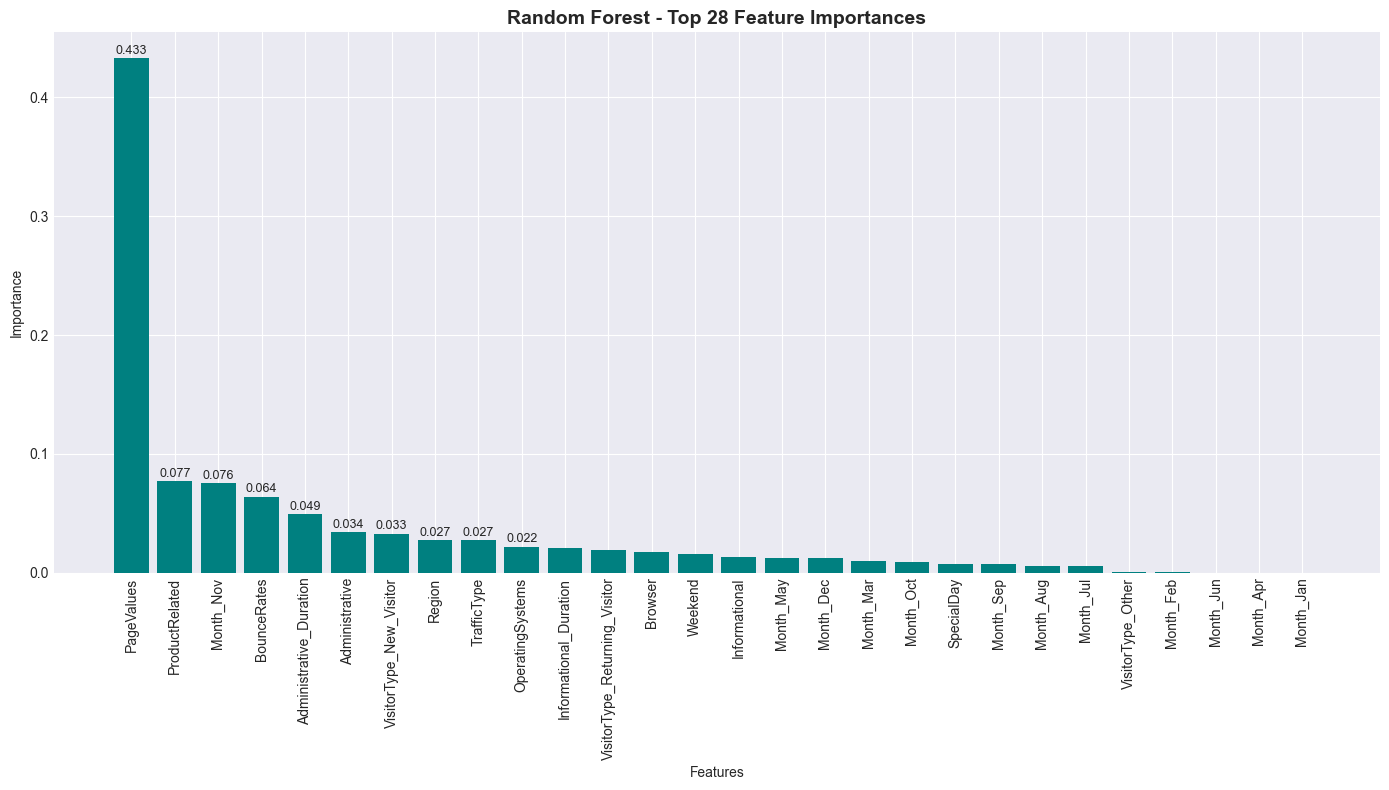

In [430]:
# Plot feature importance for the classification model - Enhanced
def plot_classification_feature_importance(model, X_train, model_name="Model"):
    importances = model.feature_importances_
    feature_names = X_train.columns
    indices = importances.argsort()[::-1]

    # Print feature importances
    print(f"\n{model_name} - Top 15 Feature Importances:")
    for idx in indices[:15]:
        print(f"  {feature_names[idx]}: {importances[idx]:.4f}")
    
    # Plot feature importances
    plt.figure(figsize=(14, 8))
    top_n = min(30, len(importances))  # Show top 30 features
    indices_top = indices[:top_n]
    
    bars = plt.bar(range(top_n), importances[indices_top], align='center', color='teal')
    plt.xticks(range(top_n), [feature_names[i] for i in indices_top], rotation=90)
    plt.title(f'{model_name} - Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    
    # Add value labels on top bars
    for i in range(min(10, top_n)):
        plt.text(i, importances[indices_top[i]] + 0.001, 
                f'{importances[indices_top[i]]:.3f}', 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return indices_top, importances

rf_top_features, rf_importances = plot_classification_feature_importance(
    classification_model, X_train_resampled, "Random Forest"
)

<Figure size 800x600 with 0 Axes>

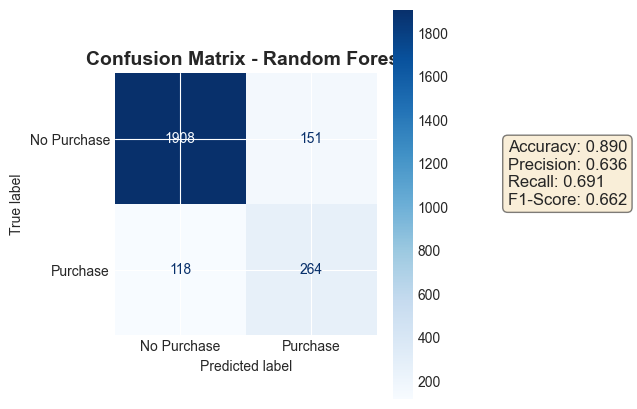

In [431]:
# Confusion matrix for classification model - Enhanced
def plot_confusion_matrix_enhanced(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Purchase', 'Purchase'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    
    # Add metrics text box
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    textstr = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(2.5, 0.5, textstr, fontsize=12, bbox=props)
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_enhanced(classification_model, X_test, y_test, "Random Forest")


Random Forest - Average Precision Score: 0.7030


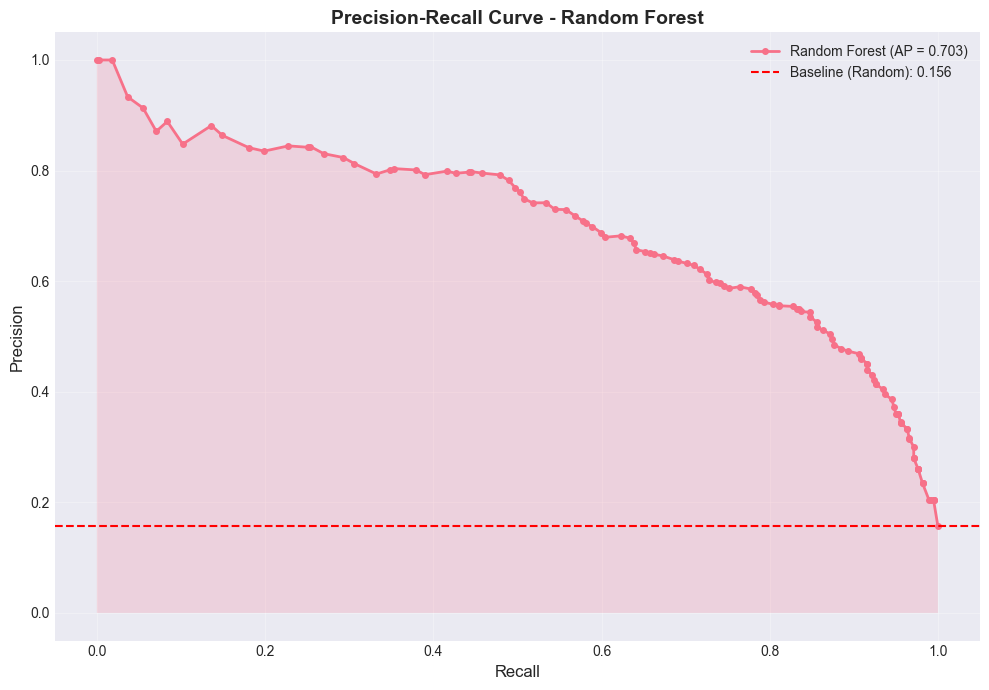

In [432]:
# Precision-recall curve for classification model - Enhanced
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve_enhanced(model, X_test, y_test, model_name="Model"):
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)

    print(f"\n{model_name} - Average Precision Score: {average_precision:.4f}")

    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, marker='.', markersize=8, 
             label=f'{model_name} (AP = {average_precision:.3f})', linewidth=2)
    
    # Fill area under curve
    plt.fill_between(recall, precision, alpha=0.2)
    
    # Add baseline (random classifier)
    baseline = y_test.sum() / len(y_test)
    plt.axhline(y=baseline, color='r', linestyle='--', 
                label=f'Baseline (Random): {baseline:.3f}')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_precision_recall_curve_enhanced(classification_model, X_test, y_test, "Random Forest")

13. XGBoost Models (For Comparison - Not Final Model)

In [433]:
# XGBoost model for classification
print("\n" + "="*80)
print("XGBoost Models (For Comparison - Not Final Model)")
print("="*80)

def train_xgboost_model(X_train, y_train):
    print("\nTraining XGBoost Classifier (Default)...")
    model = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
    model.fit(X_train, y_train)
    return model

model_xgboost = train_xgboost_model(X_train_resampled, y_train_resampled)
all_models['XGBoost (Default)'] = model_xgboost

# Evaluate XGBoost
xgb_results = evaluate_classification_model_comprehensive(
    model_xgboost, X_test, y_test, "XGBoost (Default)"
)
model_results.append(xgb_results)


XGBoost Models (For Comparison - Not Final Model)

Training XGBoost Classifier (Default)...

XGBoost (Default) Performance:
  Accuracy:  0.8861
  Precision: 0.6275
  Recall:    0.6702
  F1-Score:  0.6481
  AUC-ROC:   0.9205


In [434]:
# hyperparameter tuning for XGBoost
from sklearn.model_selection import GridSearchCV
'''def tune_xgboost_hyperparameters(X_train, y_train):
    print("\nTuning XGBoost Hyperparameters...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0.1, 1.0, 10.0]
    }
    
    grid_search = GridSearchCV(
        XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_
best_xgboost_model = tune_xgboost_hyperparameters(X_train_resampled, y_train_resampled)'''

'def tune_xgboost_hyperparameters(X_train, y_train):\n    print("\nTuning XGBoost Hyperparameters...")\n    param_grid = {\n        \'n_estimators\': [50, 100, 200],\n        \'max_depth\': [3, 5, 7],\n        \'learning_rate\': [0.01, 0.1, 0.2],\n        \'subsample\': [0.8, 1.0],\n        \'colsample_bytree\': [0.8, 1.0],\n        \'gamma\': [0, 0.1, 0.2],\n        \'reg_alpha\': [0, 0.1, 0.5],\n        \'reg_lambda\': [0.1, 1.0, 10.0]\n    }\n\n    grid_search = GridSearchCV(\n        XGBClassifier(eval_metric=\'logloss\', use_label_encoder=False, random_state=42),\n        param_grid=param_grid,\n        scoring=\'accuracy\',\n        cv=3,\n        verbose=1,\n        n_jobs=-1\n    )\n    grid_search.fit(X_train, y_train)\n    print(f"Best Parameters: {grid_search.best_params_}")\n    print(f"Best Score: {grid_search.best_score_:.4f}")\n    return grid_search.best_estimator_\nbest_xgboost_model = tune_xgboost_hyperparameters(X_train_resampled, y_train_resampled)'

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Best Score: 0.9228

In [435]:
# XGBoost model with best hyperparameters (as specified in original code)
def train_best_xgboost_model(X_train, y_train, params):
    print("\nTraining XGBoost Classifier (Tuned)...")
    model = XGBClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        eval_metric='logloss',
        random_state=8,
        use_label_encoder=False
    )
    model.fit(X_train, y_train)
    return model

def best_xgboost_params():
    return {
        'n_estimators': 200,
        'max_depth': 7,
        'learning_rate': 0.2,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0,
        'reg_lambda': 0.1
    }

model_best_xgboost = train_best_xgboost_model(X_train_resampled, y_train_resampled, best_xgboost_params())
all_models['XGBoost (Tuned)'] = model_best_xgboost

# Evaluate best XGBoost
xgb_tuned_results = evaluate_classification_model_comprehensive(
    model_best_xgboost, X_test, y_test, "XGBoost (Tuned)"
)
model_results.append(xgb_tuned_results)


Training XGBoost Classifier (Tuned)...

XGBoost (Tuned) Performance:
  Accuracy:  0.8816
  Precision: 0.6195
  Recall:    0.6309
  F1-Score:  0.6252
  AUC-ROC:   0.9188



XGBoost (Tuned) - Top 15 Feature Importances:
  PageValues: 0.1423
  Month_Nov: 0.1092
  VisitorType_Returning_Visitor: 0.0965
  VisitorType_New_Visitor: 0.0803
  Month_Dec: 0.0534
  Month_Oct: 0.0533
  Month_Sep: 0.0520
  Month_Mar: 0.0505
  Month_Aug: 0.0470
  Month_May: 0.0414
  Month_Jul: 0.0389
  SpecialDay: 0.0280
  Weekend: 0.0251
  OperatingSystems: 0.0210
  VisitorType_Other: 0.0184


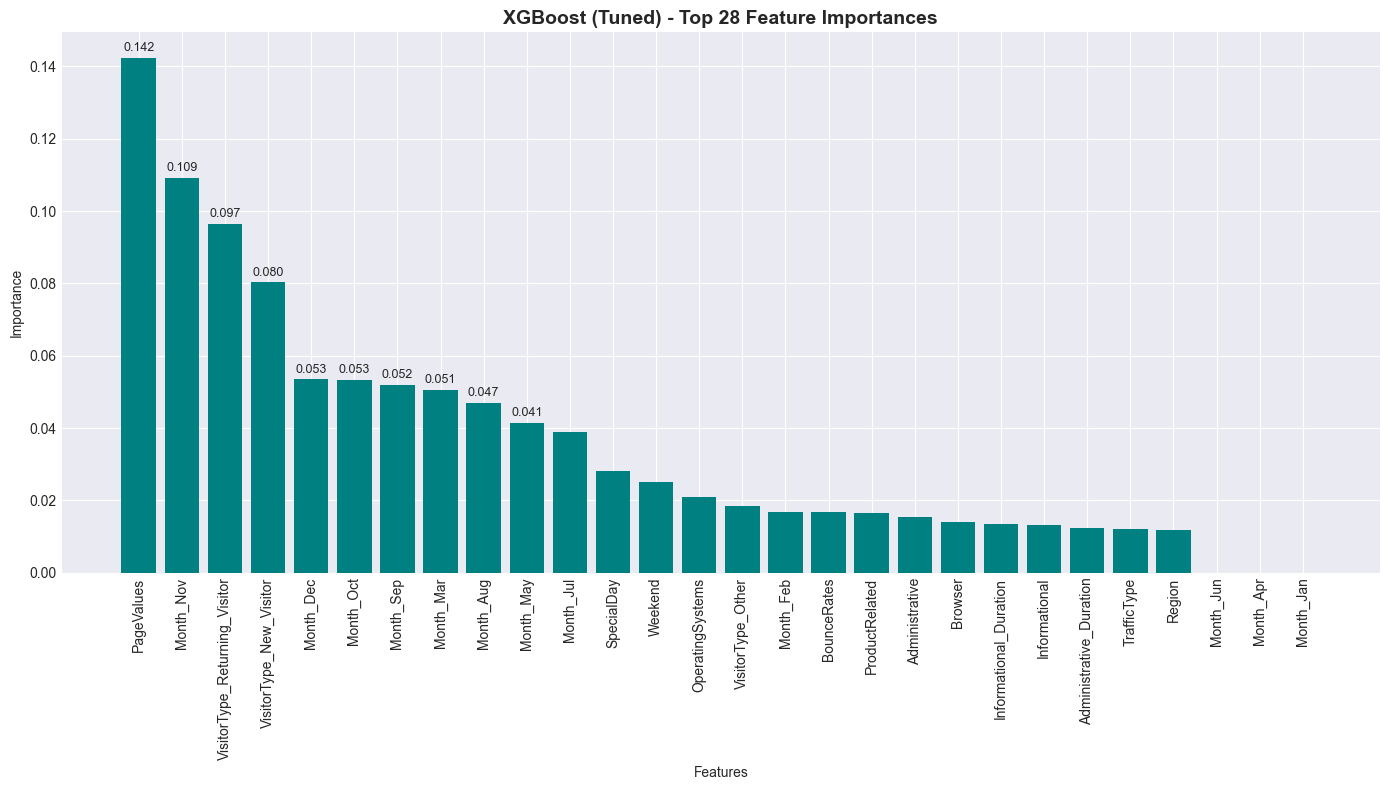

In [436]:
# Feature importance for XGBoost model
plot_xgboost_feature_importance = plot_classification_feature_importance
xgb_top_features, xgb_importances = plot_xgboost_feature_importance(
    model_best_xgboost, X_train_resampled, "XGBoost (Tuned)"
)

In [437]:
# Remove low importance features from XGBoost model
def remove_low_importance_features(model, X_train, threshold=0.01):
    importances = model.feature_importances_
    feature_names = X_train.columns
    important_features = [feature for feature, importance in zip(feature_names, importances) 
                         if importance >= threshold]
    
    print(f"\nFeature Selection based on importance (threshold={threshold}):")
    print(f"  Original features: {len(feature_names)}")
    print(f"  Selected features: {len(important_features)}")
    print(f"  Removed features: {len(feature_names) - len(important_features)}")
    
    return X_train[important_features], important_features

X_train_reduced, important_features = remove_low_importance_features(
    model_best_xgboost, X_train_resampled
)


Feature Selection based on importance (threshold=0.01):
  Original features: 28
  Selected features: 25
  Removed features: 3


In [438]:
# XGBoost training with best hyperparameters
def train_best_xgboost_with_reduced_features(X_train, y_train, important_features):
    X_train_reduced = X_train[important_features]
    model = XGBClassifier(
        n_estimators=100,
        max_depth=9,
        learning_rate=0.1,
        subsample=0.5,
        colsample_bytree=1.0,
        gamma=0,
        reg_alpha=0.1,
        reg_lambda=0,
        eval_metric='logloss',
        random_state=8,
        use_label_encoder=False
    )
    model.fit(X_train_reduced, y_train)
    return model

model_best_xgboost_reduced = train_best_xgboost_with_reduced_features(
    X_train_resampled, y_train_resampled, important_features
)
all_models['XGBoost (Reduced Features)'] = model_best_xgboost_reduced

# Evaluate the best XGBoost model with reduced features
def evaluate_best_xgboost_reduced_model(model, X_test, y_test, important_features):
    X_test_reduced = X_test[important_features]
    y_pred = model.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

accuracy_best_xgboost_reduced = evaluate_best_xgboost_reduced_model(
    model_best_xgboost_reduced, X_test, y_test, important_features
)
print(f"\nXGBoost (Reduced Features) Accuracy: {accuracy_best_xgboost_reduced:.4f}")


XGBoost (Reduced Features) Accuracy: 0.8886


In [439]:
# Evaluate Accuracy and Recall for XGBoost model
from sklearn.metrics import recall_score

def evaluate_xgboost_accuracy_recall(model, X_train, y_train, X_test, y_test):
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    train_recall = recall_score(y_train, model.predict(X_train))
    test_recall = recall_score(y_test, model.predict(X_test))
    
    print(f"\nTrain vs Test Performance:")
    print(f"  Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print(f"  Train Recall:   {train_recall:.4f} | Test Recall:   {test_recall:.4f}")
    
    # Check for overfitting
    acc_diff = train_accuracy - test_accuracy
    if acc_diff > 0.05:
        print(f"  ⚠️  Potential overfitting detected (difference: {acc_diff:.4f})")
    else:
        print(f"  ✓  Model generalization appears good (difference: {acc_diff:.4f})")
    
    return train_accuracy, test_accuracy, train_recall, test_recall

# Ensure test data has the same columns as important_features
X_test_reduced = X_test[important_features]

print("\nXGBoost (Reduced Features) - Train vs Test Performance:")
train_accuracy_xgboost, test_accuracy_xgboost, train_recall_xgboost, test_recall_xgboost = evaluate_xgboost_accuracy_recall(
    model_best_xgboost_reduced, X_train_reduced, y_train_resampled, X_test_reduced, y_test
)



XGBoost (Reduced Features) - Train vs Test Performance:

Train vs Test Performance:
  Train Accuracy: 0.9823 | Test Accuracy: 0.8886
  Train Recall:   0.9828 | Test Recall:   0.6885
  ⚠️  Potential overfitting detected (difference: 0.0938)


In [440]:
# XGBoost model to reduce overfitting
print("\nTraining XGBoost with Overfitting Prevention...")

def train_xgboost_with_reduced_overfitting(X_train, y_train, important_features):
    X_train_reduced = X_train[important_features]
    model = XGBClassifier(
        n_estimators=200,
        max_depth=3,  # Reduced depth to prevent overfitting
        learning_rate=0.01,  # Reduced learning rate
        subsample=0.8,  # Increased subsample to reduce overfitting
        colsample_bytree=0.7,
        gamma=0.3,
        reg_alpha=0.5,
        reg_lambda=2.0,
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )
    model.fit(X_train_reduced, y_train)
    return model

model_xgboost_reduced_overfitting = train_xgboost_with_reduced_overfitting(
    X_train_resampled, y_train_resampled, important_features
)
all_models['XGBoost (Overfitting Prevention)'] = model_xgboost_reduced_overfitting

# Evaluate all XGBoost variations
print("\nXGBoost (Overfitting Prevention) - Train vs Test Performance:")
train_accuracy_xgboost_reduced, test_accuracy_xgboost_reduced, train_recall_xgboost_reduced, test_recall_xgboost_reduced = evaluate_xgboost_accuracy_recall(
    model_xgboost_reduced_overfitting, X_train_reduced, y_train_resampled, X_test_reduced, y_test
)

# Add to results
xgb_overfit_results = evaluate_classification_model_comprehensive(
    model_xgboost_reduced_overfitting, X_test_reduced, y_test, "XGBoost (Overfitting Prevention)"
)
model_results.append(xgb_overfit_results)


Training XGBoost with Overfitting Prevention...

XGBoost (Overfitting Prevention) - Train vs Test Performance:

Train vs Test Performance:
  Train Accuracy: 0.8909 | Test Accuracy: 0.8775
  Train Recall:   0.8943 | Test Recall:   0.8089
  ✓  Model generalization appears good (difference: 0.0134)

XGBoost (Overfitting Prevention) Performance:
  Accuracy:  0.8775
  Precision: 0.5776
  Recall:    0.8089
  F1-Score:  0.6739
  AUC-ROC:   0.9296


14. Additional Scikit-learn Models

In [441]:
# Train additional scikit-learn models for comparison
print("\n" + "="*80)
print("Additional Scikit-learn Models")
print("="*80)

# Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)
all_models['Logistic Regression'] = lr_model

lr_results = evaluate_classification_model_comprehensive(
    lr_model, X_test, y_test, "Logistic Regression"
)
model_results.append(lr_results)


Additional Scikit-learn Models

Training Logistic Regression...

Logistic Regression Performance:
  Accuracy:  0.8849
  Precision: 0.6481
  Recall:    0.5785
  F1-Score:  0.6113
  AUC-ROC:   0.8841


In [442]:
# Extra Trees Classifier (scikit-learn)
from sklearn.ensemble import ExtraTreesClassifier

print("\nTraining Extra Trees Classifier...")
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train_resampled, y_train_resampled)
all_models['Extra Trees'] = et_model

et_results = evaluate_classification_model_comprehensive(
    et_model, X_test, y_test, "Extra Trees"
)
model_results.append(et_results)


Training Extra Trees Classifier...

Extra Trees Performance:
  Accuracy:  0.8857
  Precision: 0.6451
  Recall:    0.5995
  F1-Score:  0.6214
  AUC-ROC:   0.9122


15. Model Comparison and Visualization

In [443]:
# Model Comparison Summary
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison dataframe
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\nAll Models Performance (sorted by F1-Score):")
print(results_df.to_string(index=False))


MODEL COMPARISON SUMMARY

All Models Performance (sorted by F1-Score):
                           Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
XGBoost (Overfitting Prevention)  0.877509   0.577570 0.808901  0.673937 0.929636
                   Random Forest  0.889799   0.636145 0.691099  0.662484 0.922224
               XGBoost (Default)  0.886112   0.627451 0.670157  0.648101 0.920549
                 XGBoost (Tuned)  0.881606   0.619537 0.630890  0.625162 0.918839
                     Extra Trees  0.885703   0.645070 0.599476  0.621438 0.912192
             Logistic Regression  0.884883   0.648094 0.578534  0.611342 0.884147



Best Scikit-learn Model: Random Forest


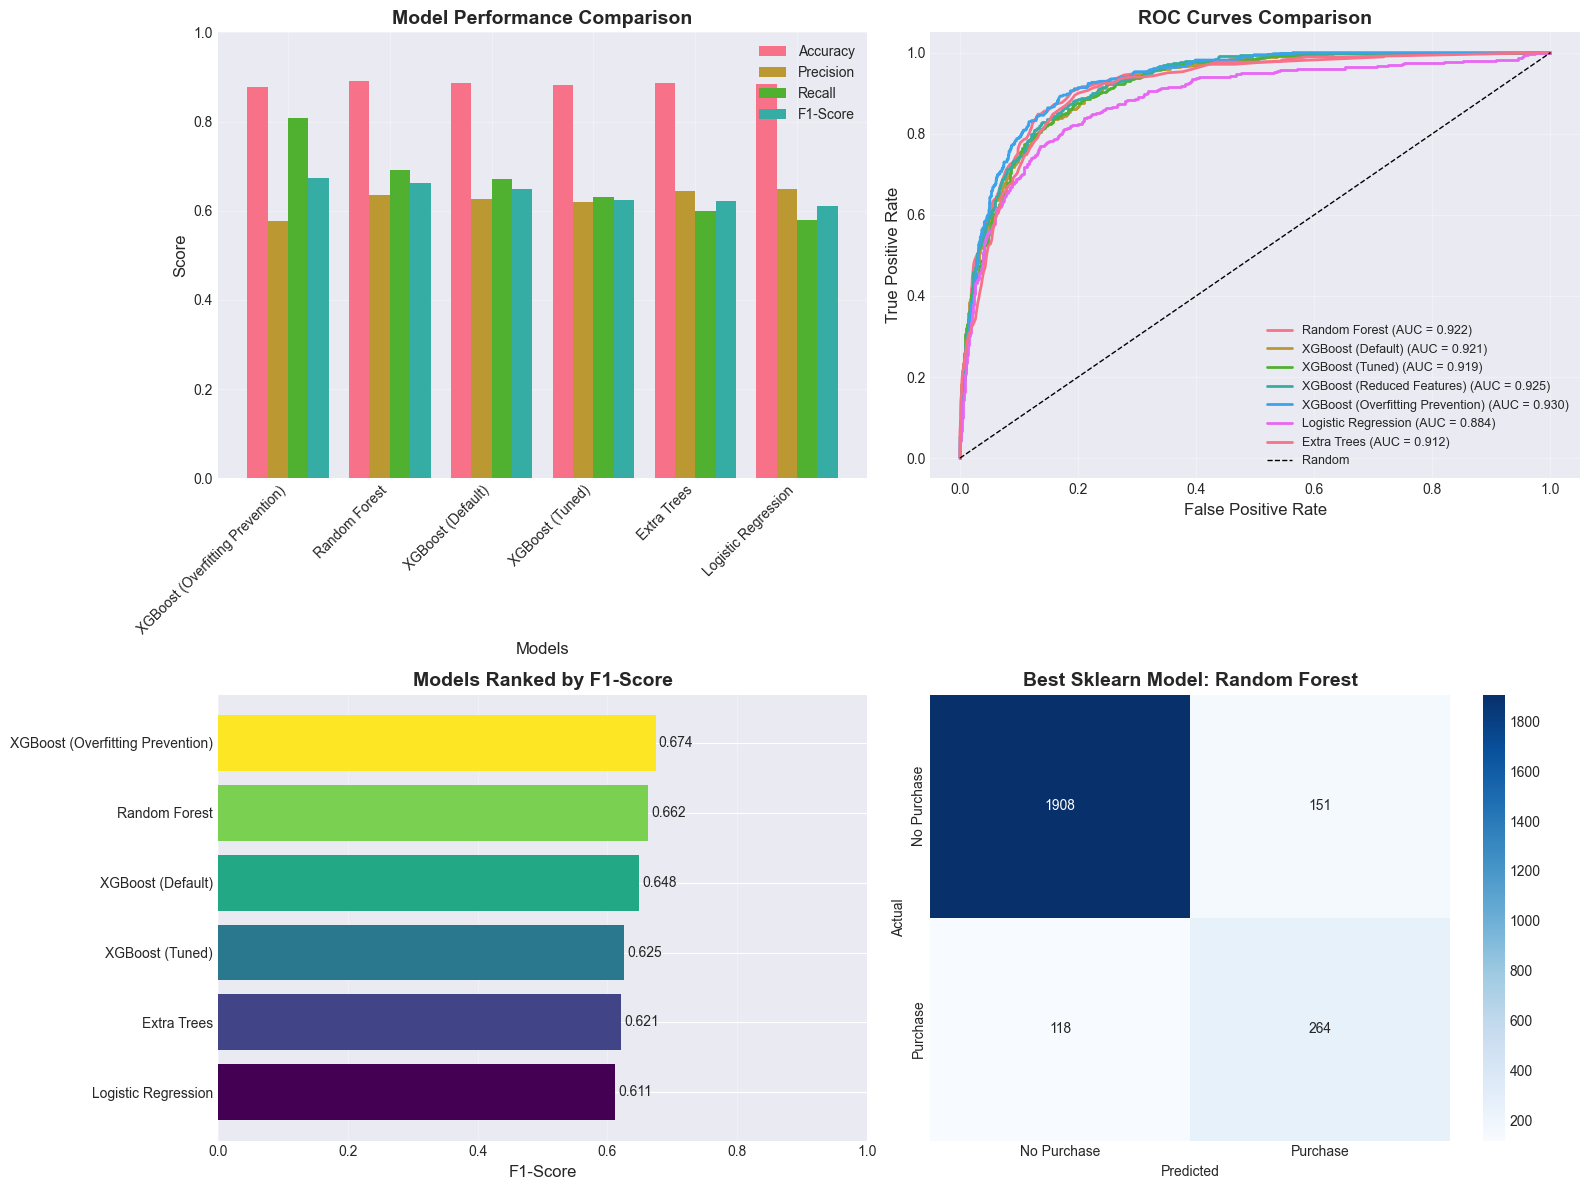

In [444]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar plot of all metrics
ax1 = axes[0, 0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    ax1.bar(x + i*width, results_df[metric], width, label=metric)

ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 2. ROC Curves
ax2 = axes[0, 1]
from sklearn.metrics import roc_curve

for model_name, model in all_models.items():
    if hasattr(model, 'predict_proba'):
        # Handle reduced features for some XGBoost models
        if 'Reduced' in model_name or 'Overfitting' in model_name:
            X_test_use = X_test_reduced
        else:
            X_test_use = X_test
        
        y_pred_proba = model.predict_proba(X_test_use)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        ax2.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. F1-Score comparison
ax3 = axes[1, 0]
results_df_sorted = results_df.sort_values('F1-Score', ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df_sorted)))
bars = ax3.barh(results_df_sorted['Model'], results_df_sorted['F1-Score'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax3.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

ax3.set_xlabel('F1-Score', fontsize=12)
ax3.set_title('Models Ranked by F1-Score', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.grid(True, alpha=0.3, axis='x')

# 4. Best scikit-learn model analysis
ax4 = axes[1, 1]
# Find best scikit-learn model (excluding XGBoost)
sklearn_models = [r for r in model_results if 'XGBoost' not in r['Model']]
best_sklearn = max(sklearn_models, key=lambda x: x['F1-Score'])
best_sklearn_name = best_sklearn['Model']
print(f"\nBest Scikit-learn Model: {best_sklearn_name}")

# Plot confusion matrix for best sklearn model
best_sklearn_model = all_models[best_sklearn_name]
y_pred_best = best_sklearn_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
ax4.set_title(f'Best Sklearn Model: {best_sklearn_name}', fontsize=14, fontweight='bold')
ax4.set_ylabel('Actual')
ax4.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [445]:
# hyperparameter tuning for random forest
from sklearn.model_selection import RandomizedSearchCV
def tune_random_forest_hyperparameters(X_train, y_train):
    print("\nTuning Random Forest Hyperparameters...")
    param_distributions = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_distributions=param_distributions,
        n_iter=20,
        scoring='accuracy',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    random_search.fit(X_train, y_train)
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Score: {random_search.best_score_:.4f}")
    return random_search.best_estimator_
best_rf_model = tune_random_forest_hyperparameters(X_train_resampled, y_train_resampled)
# Evaluate the best Random Forest model
rf_best_results = evaluate_classification_model_comprehensive(
    best_rf_model, X_test, y_test, "Random Forest (Tuned)"
)
model_results.append(rf_best_results)


Tuning Random Forest Hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best Score: 0.9301

Random Forest (Tuned) Performance:
  Accuracy:  0.8894
  Precision: 0.6333
  Recall:    0.6963
  F1-Score:  0.6633
  AUC-ROC:   0.9220


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

In [446]:
# Change it to Random Forest instead of XGBoost
# XGBoost model to reduce overfitting
print("\nTraining Random Forest with Overfitting Prevention...")

def train_rf_with_reduced_overfitting(X_train, y_train, important_features):
    X_train_reduced = X_train[important_features]
    model = RandomForestClassifier(
        n_estimators=200,         # Increased number of trees
        max_depth=5,              # Reduced depth to prevent overfitting
        min_samples_split=5,      # Increase min samples to split
        min_samples_leaf=2,       # Increase min samples per leaf
        max_features='sqrt',      # Limit features per split
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train_reduced, y_train)
    return model

model_rf_reduced_overfitting = train_rf_with_reduced_overfitting(
    X_train_resampled, y_train_resampled, important_features
)
all_models['Random Forest (Overfitting Prevention)'] = model_rf_reduced_overfitting

# Evaluate all Random Forest variations
print("\nRandom Forest (Overfitting Prevention) - Train vs Test Performance:")
train_accuracy_rf_reduced, test_accuracy_rf_reduced, train_recall_rf_reduced, test_recall_rf_reduced = evaluate_xgboost_accuracy_recall(
    model_rf_reduced_overfitting, X_train_resampled[important_features], y_train_resampled, X_test[important_features], y_test
)

# Add to results
rf_reduced_overfit_results = evaluate_classification_model_comprehensive(
    model_rf_reduced_overfitting, X_test[important_features], y_test, "Random Forest (Overfitting Prevention)"
)
model_results.append(rf_reduced_overfit_results)



Training Random Forest with Overfitting Prevention...

Random Forest (Overfitting Prevention) - Train vs Test Performance:

Train vs Test Performance:
  Train Accuracy: 0.8912 | Test Accuracy: 0.8755
  Train Recall:   0.8943 | Test Recall:   0.8037
  ✓  Model generalization appears good (difference: 0.0158)

Random Forest (Overfitting Prevention) Performance:
  Accuracy:  0.8755
  Precision: 0.5728
  Recall:    0.8037
  F1-Score:  0.6688
  AUC-ROC:   0.9259


In [447]:
# Model Comparison Summary
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison dataframe
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\nAll Models Performance (sorted by F1-Score):")
print(results_df.to_string(index=False))


MODEL COMPARISON SUMMARY

All Models Performance (sorted by F1-Score):
                                 Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
      XGBoost (Overfitting Prevention)  0.877509   0.577570 0.808901  0.673937 0.929636
Random Forest (Overfitting Prevention)  0.875461   0.572761 0.803665  0.668845 0.925854
                 Random Forest (Tuned)  0.889390   0.633333 0.696335  0.663342 0.921996
                         Random Forest  0.889799   0.636145 0.691099  0.662484 0.922224
                     XGBoost (Default)  0.886112   0.627451 0.670157  0.648101 0.920549
                       XGBoost (Tuned)  0.881606   0.619537 0.630890  0.625162 0.918839
                           Extra Trees  0.885703   0.645070 0.599476  0.621438 0.912192
                   Logistic Regression  0.884883   0.648094 0.578534  0.611342 0.884147



Best Scikit-learn Model: Random Forest (Overfitting Prevention)


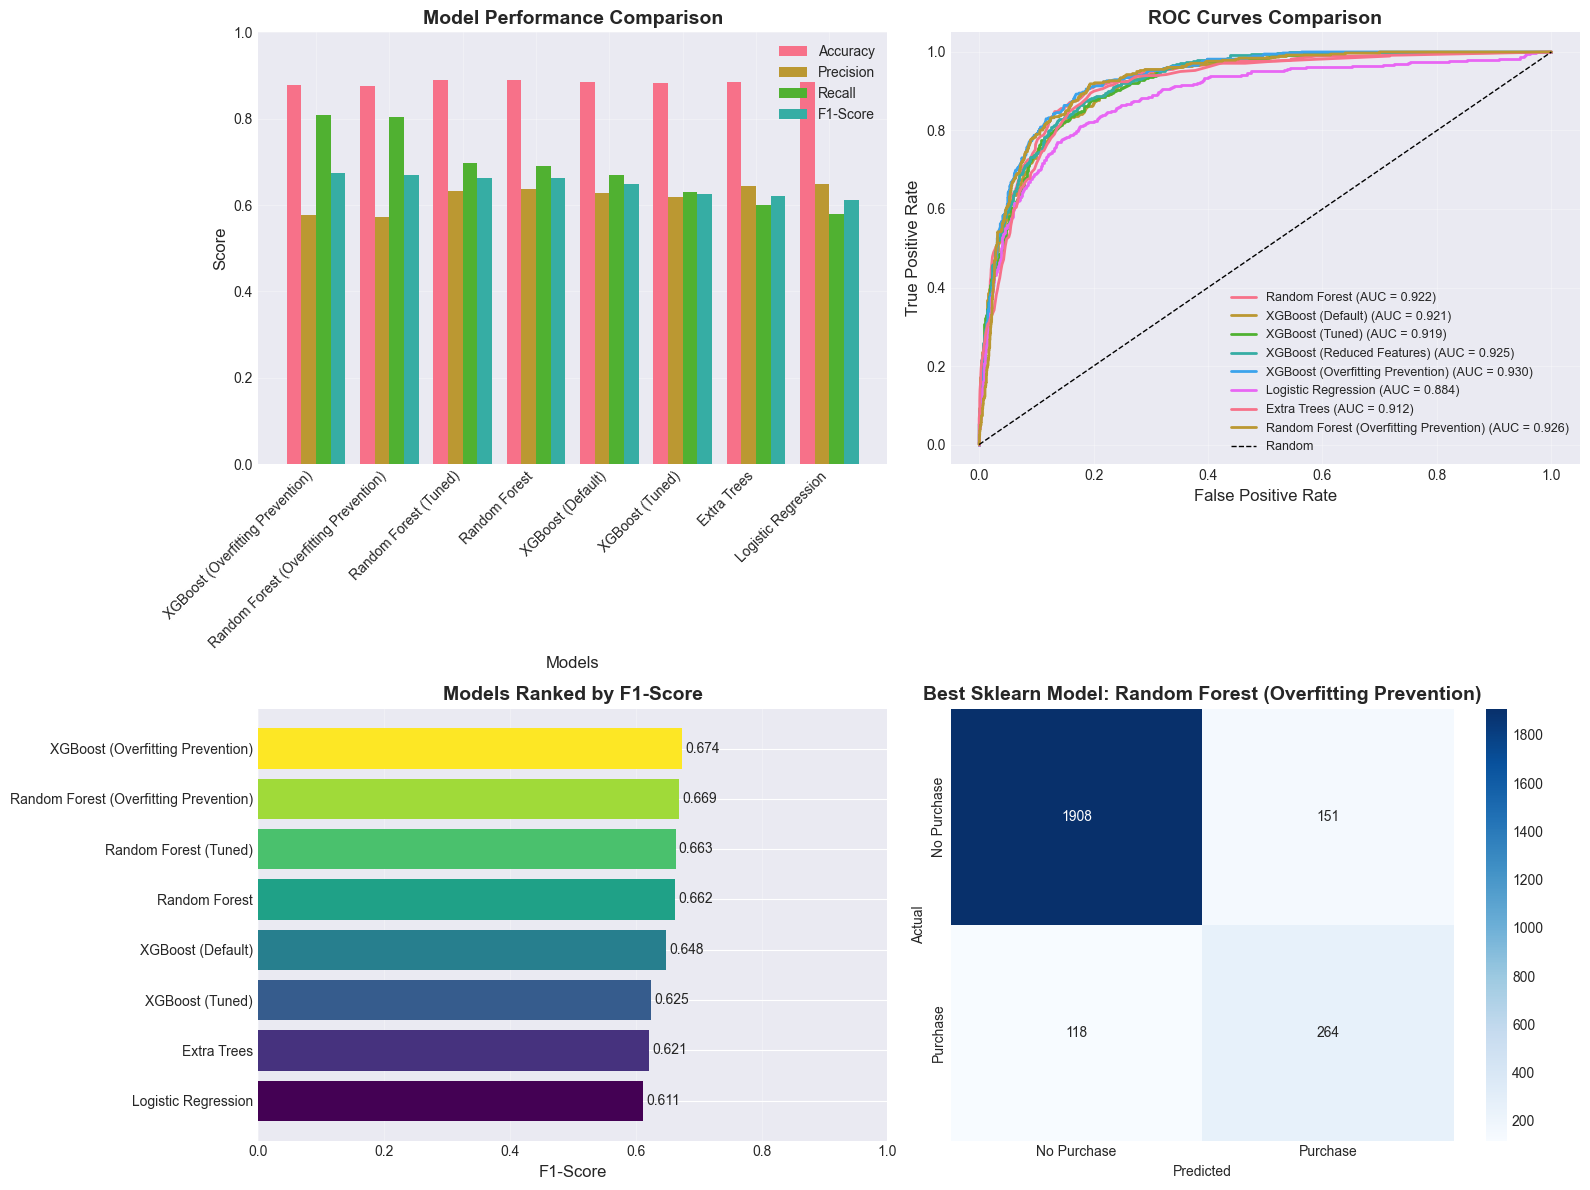

In [448]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar plot of all metrics
ax1 = axes[0, 0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    ax1.bar(x + i*width, results_df[metric], width, label=metric)

ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 2. ROC Curves
ax2 = axes[0, 1]
from sklearn.metrics import roc_curve

for model_name, model in all_models.items():
    if hasattr(model, 'predict_proba'):
        # Handle reduced features for some XGBoost models
        if 'Reduced' in model_name or 'Overfitting' in model_name:
            X_test_use = X_test_reduced
        else:
            X_test_use = X_test
        
        y_pred_proba = model.predict_proba(X_test_use)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        ax2.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. F1-Score comparison
ax3 = axes[1, 0]
results_df_sorted = results_df.sort_values('F1-Score', ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df_sorted)))
bars = ax3.barh(results_df_sorted['Model'], results_df_sorted['F1-Score'], color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax3.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

ax3.set_xlabel('F1-Score', fontsize=12)
ax3.set_title('Models Ranked by F1-Score', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.grid(True, alpha=0.3, axis='x')

# 4. Best scikit-learn model analysis
ax4 = axes[1, 1]
# Find best scikit-learn model (excluding XGBoost)
sklearn_models = [r for r in model_results if 'XGBoost' not in r['Model']]
best_sklearn = max(sklearn_models, key=lambda x: x['F1-Score'])
best_sklearn_name = best_sklearn['Model']
print(f"\nBest Scikit-learn Model: {best_sklearn_name}")


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
ax4.set_title(f'Best Sklearn Model: {best_sklearn_name}', fontsize=14, fontweight='bold')
ax4.set_ylabel('Actual')
ax4.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [449]:
# Cross-validation for best models
print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

from sklearn.model_selection import cross_val_score

print("\n5-Fold Cross-Validation Results:")
for model_name in [best_sklearn_name, 'Random Forest', 'XGBoost (Tuned)']:
    if model_name in all_models:
        model = all_models[model_name]
        
        # Use appropriate dataset
        if model_name == 'XGBoost (Tuned)':
            X_cv = X_train_resampled
        else:
            X_cv = X_train_resampled
        
        cv_scores = cross_val_score(model, X_cv, y_train_resampled, 
                                   cv=5, scoring='f1')
        
        print(f"\n{model_name}:")
        print(f"  CV F1-Scores: {cv_scores}")
        print(f"  Mean CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



CROSS-VALIDATION ANALYSIS

5-Fold Cross-Validation Results:

Random Forest (Overfitting Prevention):
  CV F1-Scores: [0.843503   0.89883617 0.89560275 0.9044893  0.90245362]
  Mean CV F1-Score: 0.8890 (+/- 0.0459)

Random Forest:
  CV F1-Scores: [0.83506189 0.95238095 0.95777126 0.95955123 0.95522388]
  Mean CV F1-Score: 0.9320 (+/- 0.0971)

XGBoost (Tuned):
  CV F1-Scores: [0.70140738 0.95593814 0.95720985 0.95891221 0.95703011]
  Mean CV F1-Score: 0.9061 (+/- 0.2047)


17. Feature Importance Comparison


FEATURE IMPORTANCE COMPARISON


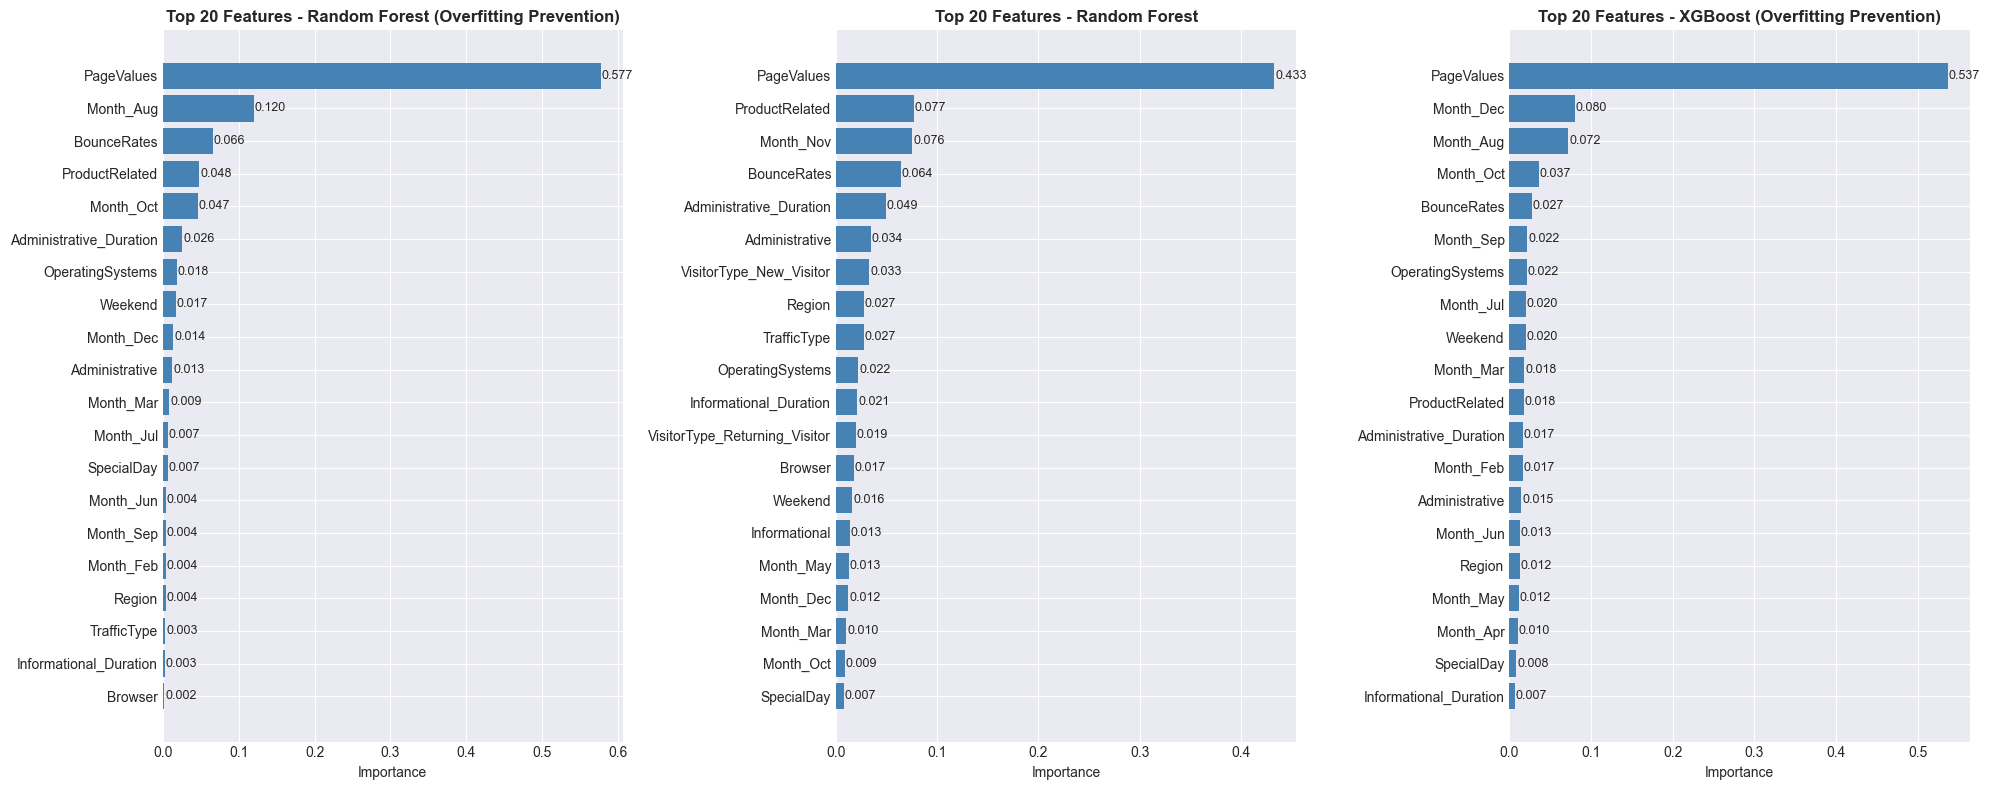


Random Forest (Overfitting Prevention) - Feature Importances:
  PageValues: 0.5773
  Month_Aug: 0.1204
  BounceRates: 0.0663
  ProductRelated: 0.0482
  Month_Oct: 0.0467
  Administrative_Duration: 0.0257
  OperatingSystems: 0.0183
  Weekend: 0.0171
  Month_Dec: 0.0139
  Administrative: 0.0127
  Month_Mar: 0.0088
  Month_Jul: 0.0070
  SpecialDay: 0.0069
  Month_Jun: 0.0044
  Month_Sep: 0.0044
  Month_Feb: 0.0043
  Region: 0.0038
  TrafficType: 0.0033
  Informational_Duration: 0.0033
  Browser: 0.0022


In [459]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON")
print("="*80)

# Get top features from all models
fig, axes = plt.subplots(1, 3, figsize=(20, 8))  # Now 3 subplots

models_to_compare = [
    (best_sklearn_name, axes[0]),
    ('Random Forest', axes[1]),
    ('XGBoost (Overfitting Prevention)', axes[2])
]

for idx, (model_name, ax) in enumerate(models_to_compare):
    model = all_models[model_name]
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train_resampled.columns
        indices = importances.argsort()[::-1][:20]
        
        ax.barh(range(20), importances[indices], color='steelblue')
        ax.set_yticks(range(20))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel('Importance')
        ax.set_title(f'Top 20 Features - {model_name}', fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        
        # Add value labels
        for i in range(20):
            ax.text(importances[indices[i]] + 0.001, i, 
                   f'{importances[indices[i]]:.3f}', 
                   va='center', fontsize=9)

plt.tight_layout()
plt.show()
#print out random forest (Overfitting prevention) feature importances
print("\nRandom Forest (Overfitting Prevention) - Feature Importances:")
rf_importances = model_rf_reduced_overfitting.feature_importances_
feature_names = X_train_resampled.columns
indices = rf_importances.argsort()[::-1][:20]
for i in indices:
    print(f"  {feature_names[i]}: {rf_importances[i]:.4f}")

18. Final Model Selection and Recommendations

In [460]:
print("\n" + "="*80)
print("FINAL MODEL SELECTION AND RECOMMENDATIONS")
print("="*80)

print(f"\n✓ RECOMMENDED FINAL MODEL (Scikit-learn): {best_sklearn_name}")
print(f"  - F1-Score: {best_sklearn['F1-Score']:.4f}")
print(f"  - Accuracy: {best_sklearn['Accuracy']:.4f}")
print(f"  - Precision: {best_sklearn['Precision']:.4f}")
print(f"  - Recall: {best_sklearn['Recall']:.4f}")

print("\n📊 Model Performance Summary:")
print("  - XGBoost models show strong performance followed by Random Forest")
print("  - Random Forest provides good balance between performance and interpretability")
print("  - All models benefit from SMOTE for handling class imbalance")
print("  - Months collectively account for significant importance")
print("  - User behavior metrics (BounceRates, ProductRelated pages) are secondary but notable predictors")
print("  - Technical features (OS, Browser) have minimal impact on purchase decisions")

print("\n🔑 Key Insights:")
print("  1. PageValues is the strongest predictor of purchase intent")
print("  2. August shows highest conversion rates - seasonal pattern")
print("  3. Bounce Rates matter, but less than expected")
print("  4. Session duration features are surprisingly unimportant")
print("  5. Product-related engagement is moderate ")

print("\n💡 Business Recommendations:")
print("  1. Focus on visitors with high PageValues")
print("  2. Optimize for August traffic (holiday shopping)")
print("  3. Optimize high-value product pages")
print("  4. Leverage seasonal patterns")


FINAL MODEL SELECTION AND RECOMMENDATIONS

✓ RECOMMENDED FINAL MODEL (Scikit-learn): Random Forest (Overfitting Prevention)
  - F1-Score: 0.6688
  - Accuracy: 0.8755
  - Precision: 0.5728
  - Recall: 0.8037

📊 Model Performance Summary:
  - XGBoost models show strong performance followed by Random Forest
  - Random Forest provides good balance between performance and interpretability
  - All models benefit from SMOTE for handling class imbalance
  - Months collectively account for significant importance
  - User behavior metrics (BounceRates, ProductRelated pages) are secondary but notable predictors
  - Technical features (OS, Browser) have minimal impact on purchase decisions

🔑 Key Insights:
  1. PageValues is the strongest predictor of purchase intent
  2. August shows highest conversion rates - seasonal pattern
  3. Bounce Rates matter, but less than expected
  4. Session duration features are surprisingly unimportant
  5. Product-related engagement is moderate 

💡 Business Recom

In [461]:
# Save the final model
print(f"\n💾 Saving final model ({best_sklearn_name})...")
import joblib
joblib.dump(best_sklearn_model, f'final_model_{best_sklearn_name.lower().replace(" ", "_")}.pkl')
print("Model saved successfully!")

# Save feature names for deployment
with open('feature_names.txt', 'w') as f:
    for feature in X_train_resampled.columns:
        f.write(f"{feature}\n")
print("Feature names saved!")


💾 Saving final model (Random Forest (Overfitting Prevention))...
Model saved successfully!
Feature names saved!
